In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from itertools import combinations
import os
from scipy.spatial import distance
import re
from scipy.stats import spearmanr
import matplotlib.colors as mcolors
from scipy.stats import pearsonr
from scipy.stats import linregress

In [41]:
os.chdir("/lab/wengpj01/expression_pipeline/results_20231031/")

In [42]:
ax_file = "/lab/wengpj01/expression_pipeline/results_20231031/axolotl_norm.csv"
bull_file = "/lab/wengpj01/expression_pipeline/results_20231031/bullfrog_norm.csv"
cane_file = "/lab/wengpj01/expression_pipeline/results_20231031/cane_norm.csv"
terr_file = "/lab/wengpj01/expression_pipeline/results_20231031/terribilis_norm.csv"
xen_file = "/lab/wengpj01/expression_pipeline/results_20231031/xenopus_norm.csv"

In [43]:
# Read the CSV file, specifying the second column as the index (row names) and skipping the first column
ax = pd.read_csv(ax_file, index_col=0, usecols=lambda column: column != 'Unnamed: 0')
bull = pd.read_csv(bull_file, index_col=0, usecols=lambda column: column != 'Unnamed: 0')
cane = pd.read_csv(cane_file, index_col=0, usecols=lambda column: column != 'Unnamed: 0')
terr = pd.read_csv(terr_file, index_col=0, usecols=lambda column: column != 'Unnamed: 0')
xen = pd.read_csv(xen_file, index_col=0, usecols=lambda column: column != 'Unnamed: 0')

# # Rename the columns based on the first row
# ax.columns = ax.iloc[0]

# Drop the first row (since it's now the column names)
# ax = ax.iloc[1:]

In [44]:
# Create a dictionary to store the counts for each column
non_zero_counts = {}

# Iterate through each column in the DataFrame
for column in bull.columns:
    # Calculate the number of non-zero values in the column
    non_zero_count = (bull[column] != 0).sum()
    
    # Store the count in the dictionary with the column name as the key
    non_zero_counts[column] = non_zero_count

# Convert the dictionary to a DataFrame if needed
non_zero_counts_bull = pd.DataFrame(list(non_zero_counts.items()), columns=['Column', 'NonZeroRowCount'])

# Create a dictionary to store the counts for each column
count_bull_10 = {}

# Iterate through each column in the bull DataFrame
for column in bull.columns:
    # Calculate the number of rows where the value is greater than 10
    count = (bull[column] > 10).sum()
    
    # Store the count in the dictionary with the column name as the key
    count_bull_10[column] = count

# Convert the dictionary to a DataFrame if needed
count_bull_10_df = pd.DataFrame(list(count_bull_10.items()), columns=['Column', 'RowCountGreaterThan10'])


In [45]:
def count_non_zero_values(dataframes, dataframe_names):
    summary_data = []
    
    # Define regular expression patterns for each group of columns
    pattern_1 = r'^Counts_1\..*'
    pattern_2 = r'^Counts_2\..*'
    pattern_3 = r'^Counts_3\..*'
    
    for df in dataframes:
        # Find columns that match each pattern in the current DataFrame
        matching_columns_1 = [col for col in df.columns if re.match(pattern_1, col)]
        matching_columns_2 = [col for col in df.columns if re.match(pattern_2, col)]
        matching_columns_3 = [col for col in df.columns if re.match(pattern_3, col)]

        # Create boolean masks for each group of matching columns
        mask_1 = df[matching_columns_1] != 0
        mask_2 = df[matching_columns_2] != 0
        mask_3 = df[matching_columns_3] != 0

        # Check if there is at least one non-zero value in each group of matching columns for each row
        rows_with_non_zero_1 = mask_1.any(axis=1)
        rows_with_non_zero_2 = mask_2.any(axis=1)
        rows_with_non_zero_3 = mask_3.any(axis=1)

        # Calculate the counts for each group of matching columns
        count_rows_with_non_zero_1 = rows_with_non_zero_1.sum()
        count_rows_with_non_zero_2 = rows_with_non_zero_2.sum()
        count_rows_with_non_zero_3 = rows_with_non_zero_3.sum()
        
        # Count the number of rows in Counts_1
        count_rows_in_counts_1 = df[matching_columns_1].shape[0]

        summary_data.append({
            'Counts_1': count_rows_with_non_zero_1,
            'Counts_2': count_rows_with_non_zero_2,
            'Counts_3': count_rows_with_non_zero_3,
            'Total': count_rows_in_counts_1
        })

    # Create a summary DataFrame with the provided names as index
    summary_df2 = pd.DataFrame(summary_data, index=dataframe_names)
    
    # Create summary_df4 with the desired columns
    summary_df4 = pd.DataFrame()
    summary_df4['Counts_1_Percentage'] = (summary_df2['Counts_1'] / summary_df2['Total']) * 100
    summary_df4['Counts_2_Percentage'] = (summary_df2['Counts_2'] / summary_df2['Total']) * 100
    summary_df4['Counts_3_Percentage'] = (summary_df2['Counts_3'] / summary_df2['Total']) * 100

    # Copy the index from summary_df2 to summary_df4
    summary_df4.index = summary_df2.index
    
    return summary_df4

In [46]:
summary_df = count_non_zero_values([ax, bull, cane, terr, xen],["axolotl", "bullfrog", "cane", "dart", "clawed"])

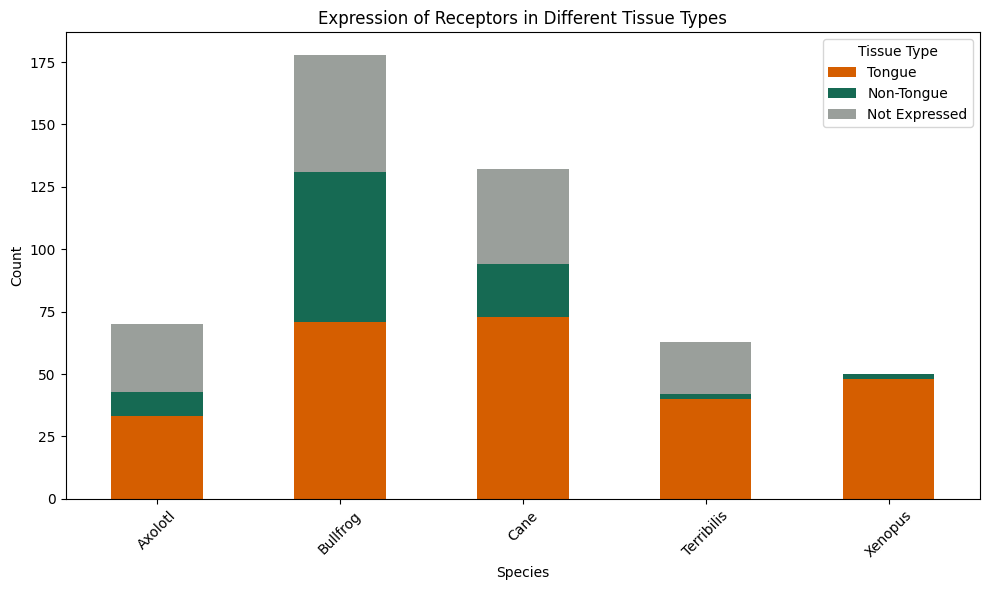

In [47]:
def categorize_tissues(columns):
    tongue_columns = [col for col in columns if re.match(r'^Counts_1\.1$|^Counts_2\.1$|^Counts_3\.1$', col)]
    non_tongue_columns = [col for col in columns if col not in tongue_columns]
    return tongue_columns, non_tongue_columns

def count_non_zero_values(dataframes, dataframe_names):
    summary_data = []
    
    for df in dataframes:
        tongue_columns, non_tongue_columns = categorize_tissues(df.columns)
        
        # Check if there is expression in tongue tissues for each row
        expressed_in_tongue = (df[tongue_columns] != 0).any(axis=1)
        
        # Check if there is expression in non-tongue tissues for each row
        expressed_in_non_tongue = (df[non_tongue_columns] != 0).any(axis=1)
        
        # Calculate counts for each category
        count_tongue = expressed_in_tongue.sum()
        count_non_tongue = ((~expressed_in_tongue) & expressed_in_non_tongue).sum()
        count_not_expressed = (~(expressed_in_tongue | expressed_in_non_tongue)).sum()
        
        # Count the number of rows in each category
        count_total = len(df)

        summary_data.append({
            'Tongue': count_tongue,
            'Non-Tongue': count_non_tongue,
            'Not Expressed': count_not_expressed,
            'Total': count_total
        })

    # Create a summary DataFrame with the provided names as index
    summary_df = pd.DataFrame(summary_data, index=dataframe_names)
    
    # Create DataFrame for plotting
    plot_data = summary_df[['Tongue', 'Non-Tongue', 'Not Expressed']].copy()
    
    return plot_data



# Example usage:
dataframes = [ax, bull, cane, terr, xen]
dataframe_names = ['Axolotl', 'Bullfrog', 'Cane', 'Terribilis', 'Xenopus']

plot_data = count_non_zero_values(dataframes, dataframe_names)
colors = ['#D55E00', '#166A53', '#9A9F9B']  # First color: D55E00, Second color: 166A53, Third color: 9A9F9B

plot_data.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
plt.title('Expression of Receptors in Different Tissue Types')
plt.xlabel('Species')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Tissue Type')
plt.grid(False)  # Remove gridlines

# Adjust the layout
plt.tight_layout()
plt.savefig('/lab/wengpj01/expression_pipeline/results_20231031/barplots_2024.pdf')

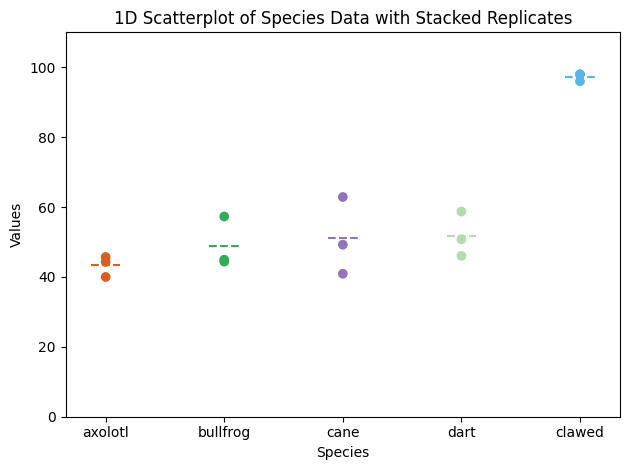

In [48]:
# Custom color palette
custom_palette = ['#D36027', '#35AB58', '#9374B4', '#B4DBAF', '#5AB4E5']

# Extract the data from the summary DataFrame
data = summary_df.values  # Assuming summary_df contains the data

# Number of replicates
num_replicates = data.shape[1]

# Create a figure and axis
fig, ax2 = plt.subplots()

# Set the x-axis positions for the species
x_positions = np.arange(len(summary_df.index))

# Create the 1D scatterplot with stacked replicates
for replicate in range(num_replicates):
    y_values = data[:, replicate]
    ax2.scatter(x_positions, y_values, label=f'Replicate {replicate + 1}', color=custom_palette)
    
# Set the y-axis limits
ax2.set_ylim(0, 110)

# Set labels and title
ax2.set_xlabel('Species')
ax2.set_ylabel('Values')
ax2.set_title('1D Scatterplot of Species Data with Stacked Replicates')

# Set x-axis labels to be species names
ax2.set_xticks(x_positions)
ax2.set_xticklabels(summary_df.index)


# Add a horizontal line for the mean
mean_values = np.mean(data, axis=1)
bin_width = 1 / 4  # Adjust as needed
for i, mean_value in enumerate(mean_values):
    x_start = x_positions[i] - bin_width / 2
    x_end = x_positions[i] + bin_width / 2
    ax2.hlines(y=mean_value, xmin=x_start, xmax=x_end, color=custom_palette[i], linestyle='--', label='Mean Value')

# Adjust the layout
plt.tight_layout()
plt.savefig('/lab/wengpj01/expression_pipeline/results_20231031/expressed_receptors_tissue_replicate.pdf')

In [49]:
# List of dataframes and their associated names
dataframes = [ax, bull, cane, terr, xen]  # Assuming you have these dataframes
dataframe_names = ['ax', 'bull', 'cane', 'terr', 'xen']

# Initialize empty DataFrames for each replicate
replicate_1 = pd.DataFrame(index=dataframe_names, columns=[f'1.{i}' for i in range(1, 8)])
replicate_2 = pd.DataFrame(index=dataframe_names, columns=[f'2.{i}' for i in range(1, 8)])
replicate_3 = pd.DataFrame(index=dataframe_names, columns=[f'3.{i}' for i in range(1, 8)])

# Loop through dataframes and populate replicate DataFrames
for i, df in enumerate(dataframes):
    # Count the number of rows greater than 0 for each column
    count_replicate_1 = (df.filter(like='1.').gt(0).sum()).values
    count_replicate_2 = (df.filter(like='2.').gt(0).sum()).values
    count_replicate_3 = (df.filter(like='3.').gt(0).sum()).values

    # Update the respective replicate DataFrame
    replicate_1.loc[dataframe_names[i]] = count_replicate_1
    replicate_2.loc[dataframe_names[i]] = count_replicate_2
    replicate_3.loc[dataframe_names[i]] = count_replicate_3

# Convert the count values to integers
replicate_1 = replicate_1.astype(int)
replicate_2 = replicate_2.astype(int)
replicate_3 = replicate_3.astype(int)

In [50]:
# Assuming dataframes is a list containing your DataFrames
dataframes = [ax, bull, cane, terr, xen]
unique_not_tongue = pd.DataFrame(index=['ax', 'bull', 'cane', 'terr', 'xen'], columns=['Count'])

for i, df in enumerate(dataframes):
    criteria = (df['Counts_1.1'] < 0.01) & (df['Counts_2.1'] < 0.01) & (df['Counts_3.1'] < 0.01)
    
    # Check if the average of specific columns is greater than 0.01
    other_column_criteria = ((df.drop(['Counts_1.1', 'Counts_2.1', 'Counts_3.1'], axis=1) > 0.01).any(axis=1))
    
    count_rows = len(df[criteria & other_column_criteria])
    
    unique_not_tongue.at[unique_not_tongue.index[i], 'Count'] = count_rows


# Print or use the unique_not_tongue DataFrame as needed
print(unique_not_tongue)

     Count
ax       8
bull    59
cane    21
terr     2
xen      1


In [51]:
#temp=ax[(ax['Counts_1.1'] < 0.01) & (ax['Counts_2.1'] < 0.01) & (ax['Counts_3.1'] < 0.01)][(ax.drop(['Counts_1.1', 'Counts_2.1', 'Counts_3.1'], axis=1) > 0.01).any(axis=1)]
temp=xen[(xen['Counts_1.1'] < 0.01) & (xen['Counts_2.1'] < 0.01) & (xen['Counts_3.1'] < 0.01)][(xen.drop(['Counts_1.1', 'Counts_2.1', 'Counts_3.1'], axis=1) > 0.01).any(axis=1)]
temp

/tmp/ipykernel_3600201/745544815.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp=xen[(xen['Counts_1.1'] < 0.01) & (xen['Counts_2.1'] < 0.01) & (xen['Counts_3.1'] < 0.01)][(xen.drop(['Counts_1.1', 'Counts_2.1', 'Counts_3.1'], axis=1) > 0.01).any(axis=1)]


,Counts_1.1,Counts_1.2,Counts_1.3,Counts_1.4,Counts_1.5,Counts_1.6,Counts_1.7,Counts_2.1,Counts_2.2,Counts_2.3,...,Counts_2.5,Counts_2.6,Counts_2.7,Counts_3.1,Counts_3.2,Counts_3.3,Counts_3.4,Counts_3.5,Counts_3.6,Counts_3.7
id,,,,,,,,,,,,,,,,,,,,,
NC_030677.2:142784561-142785511,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010374,0.0


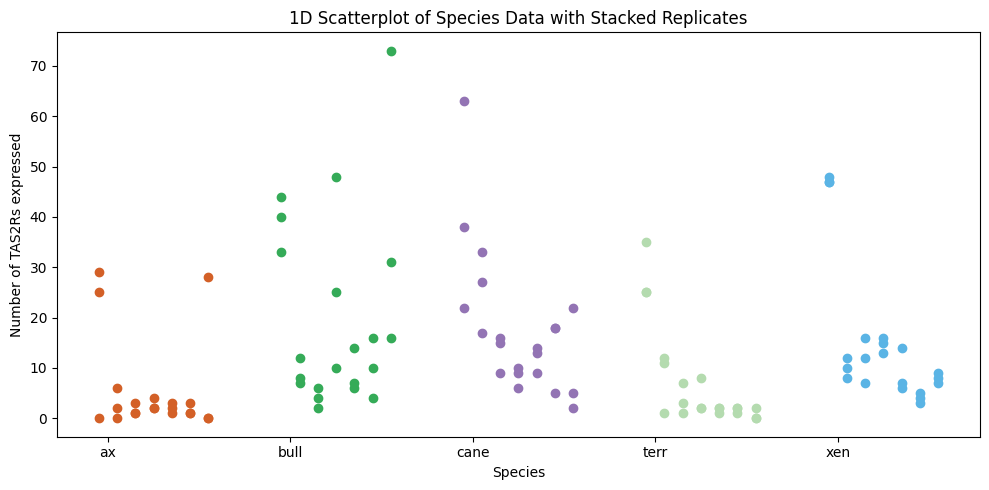

In [52]:
# Scatterplot of Species Data with Stacked Replicates by tissue
# Dataframes containing the counts
replicates = [replicate_1, replicate_2, replicate_3]

# Species names
species_names = replicate_1.index

# Define colors for species clusters
colors = ['#D36027', '#35AB58', '#9374B4', '#B4DBAF', '#5AB4E5']

# Create a figure and axis
fig, ax2 = plt.subplots(figsize=(10, 5))

# Names for the columns in replicate_1
column_names = ["Tongue", "Brain", "Stomach", "Intestines", "VSkin", "DSkin", "Liver"]

# Width of each column within a cluster
column_width = 0.1

# Loop through each column name and create scatter plots for each species cluster
for i, column_name in enumerate(column_names):
    for j, species in enumerate(species_names):
        # Get the data for the current species and column
        data = [replicates[k].loc[species][i] for k in range(3)]
        
        # Calculate x positions for the scatter points
        x_positions_cluster = np.arange(len(species_names)) + i * column_width - (0.5 * column_width)
        x_positions_point = [x_positions_cluster[j],x_positions_cluster[j],x_positions_cluster[j]]
        
        # Create scatter plots
        ax2.scatter(x_positions_point, data, label=column_name, color=colors[j])

# Set labels and title
ax2.set_xlabel('Species')
ax2.set_ylabel('Number of TAS2Rs expressed')
ax2.set_title('1D Scatterplot of Species Data with Stacked Replicates')

# Set x-axis labels to be species names
ax2.set_xticks(np.arange(len(species_names)))
ax2.set_xticklabels(species_names)


# Adjust the layout
plt.tight_layout()

plt.savefig('/lab/wengpj01/expression_pipeline/results_20231031/expressed_receptors_replicate.pdf')

In [53]:
def count_rows_above_threshold(df, threshold):
    # Initialize a counter
    counter = 0

    # Iterate through rows in the DataFrame
    for index, row in df.iterrows():
        # Check if any value in the row is greater than or equal to the threshold
        if (row >= threshold).any():
            counter += 1

    # Calculate the fraction of rows meeting the condition
    total_rows = len(df)
    fraction = 100* round(counter / total_rows,2)

    return counter, fraction

In [54]:
def count_rows_above_threshold_min1(df3, threshold):
    # Initialize a counter
    counter = 0

    # Iterate through rows in the DataFrame
    for index, row in df3.iterrows():
        # Initialize a dictionary to count occurrences of each suffix
        suffix_counts = {}

        # Iterate through columns in the row
        for colname in row.index:
            # Check if the value is greater than or equal to the threshold
            if row[colname] >= threshold:
                # Extract the suffix (e.g., '.2') from the column name
                suffix = colname.split('.')[-1]

                # Increment the count for this suffix in the dictionary
                suffix_counts[suffix] = suffix_counts.get(suffix, 0) + 1

        # Check if there is at least one occurrences of any suffix
        if any(count >= 1 for count in suffix_counts.values()):
            counter += 1

    # Calculate the fraction of rows meeting the condition
    total_rows = len(df3)
    fraction = 100 * round(counter / total_rows, 4)
    
    counter = int(counter)

    return counter, fraction

In [55]:
count_rows_above_threshold_min1(bull, 0.01)

(130, 73.03)

In [56]:
def count_rows_above_threshold_min2(df2, threshold):
    # Initialize a counter
    counter = 0

    # Iterate through rows in the DataFrame
    for index, row in df2.iterrows():
        # Initialize a dictionary to count occurrences of each suffix
        suffix_counts = {}

        # Iterate through columns in the row
        for colname in row.index:
            # Check if the value is greater than or equal to the threshold
            if row[colname] >= threshold:
                # Extract the suffix (e.g., '.2') from the column name
                suffix = colname.split('.')[-1]

                # Increment the count for this suffix in the dictionary
                suffix_counts[suffix] = suffix_counts.get(suffix, 0) + 1

        # Check if there are at least two occurrences of any suffix
        if any(count >= 2 for count in suffix_counts.values()):
            counter += 1

    # Calculate the fraction of rows meeting the condition
    total_rows = len(df)
    fraction = 100 * round(counter / total_rows, 4)
    
    counter = int(counter)

    return counter, fraction

/tmp/ipykernel_3600201/1848050784.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['ax', 'bull', 'cane', 'terr', 'xen'], y=results_df['Fraction'], palette=custom_palette)


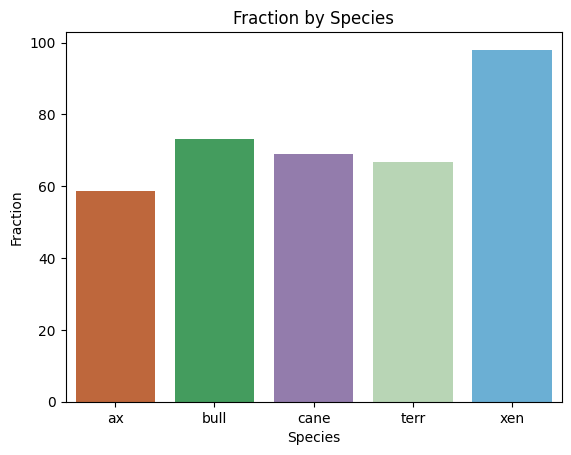

In [57]:
# Generates figure 4C
# Create a dictionary to store the results
results = {}

species_list = ['ax', 'bull', 'cane', 'terr', 'xen']
sample_names = ['Tongue', 'Brain', 'Stomach', 'Intestines', 'VSkin', 'DSkin', 'Liver']
for species in species_list:
    # Calculate the count and fraction for the current species
    count, fraction = count_rows_above_threshold_min1(eval(species), 0.01)  #CHANGE THIS FOR THRESHOLD 10 vs 1
    count2, fraction2 = count_rows_above_threshold_min1(eval(species), -1)
    
    # Cast the count to an integer
    count = int(count)
    
    # Store the results in the dictionary
    results[species] = {'Total': count, 'Fraction': fraction, 'Genome':count2}


# Create a DataFrame from the results dictionary
results_df = pd.DataFrame(results).T
results_df.index.name = 'Species'
results_df["Total"] = results_df["Total"].astype(int)
results_df["Genome"] = results_df["Genome"].astype(int)

new_order = ["Total", "Genome", "Fraction"]
results_df = results_df[new_order]

# Print the results
results_df

# Use the custom color palette
custom_palette = ['#D36027', '#35AB58', '#9374B4', '#B4DBAF', '#5AB4E5']
sns.barplot(x=['ax', 'bull', 'cane', 'terr', 'xen'], y=results_df['Fraction'], palette=custom_palette)

# Add labels and title
plt.xlabel('Species')
plt.ylabel('Fraction')
plt.title('Fraction by Species')
plt.savefig('/lab/wengpj01/expression_pipeline/results_20231031/percent_expressed_total.pdf')

In [58]:
results_df
unique_not_tongue["Total"] = results_df["Total"]
unique_not_tongue["Genome"] = results_df["Genome"]
unique_not_tongue["Fraction"] = ((100*unique_not_tongue["Count"]/results_df["Total"]))
unique_not_tongue

,Count,Total,Genome,Fraction
ax,8,41,70,19.512195
bull,59,130,178,45.384615
cane,21,91,132,23.076923
terr,2,42,63,4.761905
xen,1,49,50,2.040816


In [59]:
correlation, p_value = pearsonr(unique_not_tongue['Fraction'], unique_not_tongue['Genome'])
print(correlation)
print(p_value)

0.938765221096169
0.018021929537979375


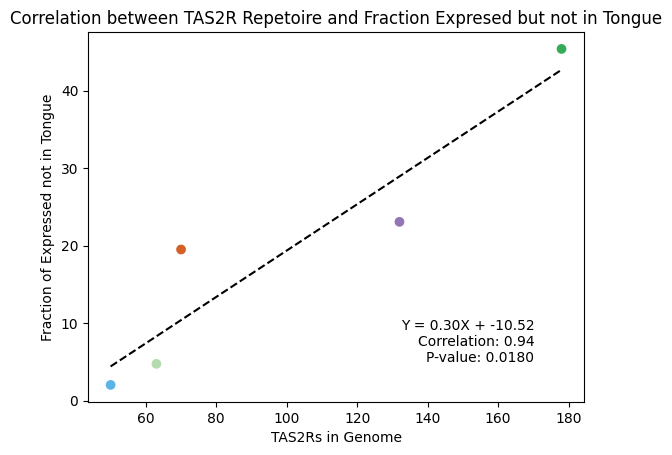

In [60]:
# Generates figure 4F
# Specify the colors
colors = ['#D36027', '#35AB58', '#9374B4', '#B4DBAF', '#5AB4E5']

# Convert the 'Fraction' and 'Genome' columns to NumPy arrays with float data type
y_vals = np.array(unique_not_tongue['Fraction'], dtype=np.float64)
x_vals = np.array(unique_not_tongue['Genome'], dtype=np.float64)

# Create a scatter plot
plt.scatter(x_vals, y_vals, c=colors)
# Calculate the linear regression line
coefficients = np.polyfit(x_vals, y_vals, 1)
slope, intercept = coefficients

# Add the line of best fit
x_vals_fit = np.linspace(x_vals.min(), x_vals.max(), 100)
y_vals_fit = slope * x_vals_fit + intercept
plt.plot(x_vals_fit, y_vals_fit, color='black', linestyle='--')

# Add the regression equation, correlation coefficient, and p-value in the lower right-hand corner
equation = f'Y = {slope:.2f}X + {intercept:.2f}'
correlation_text = f'Correlation: {correlation:.2f}\nP-value: {p_value:.4f}'
plt.text(0.9, 0.1, f'{equation}\n{correlation_text}', transform=plt.gca().transAxes, ha='right', va='bottom')


# Add labels and title
plt.xlabel('TAS2Rs in Genome')
plt.ylabel('Fraction of Expressed not in Tongue')
plt.title('Correlation between TAS2R Repetoire and Fraction Expresed but not in Tongue')
plt.savefig('/lab/wengpj01/expression_pipeline/results_20231031/corr_TAS2Rnum_expEO.pdf')

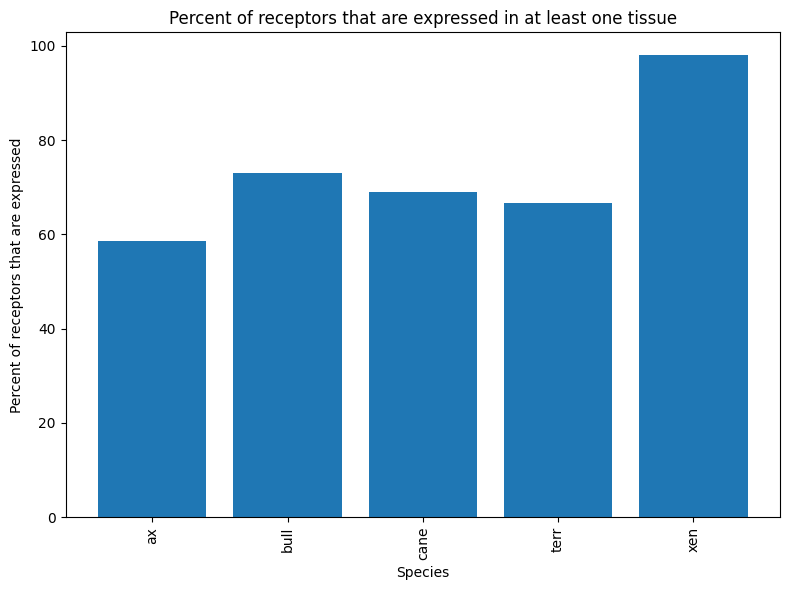

In [61]:
# Extract the "Fraction" column from results_df
fraction_data = results_df['Fraction']

# Create a barplot
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
plt.bar(range(len(fraction_data)), fraction_data)
plt.xlabel("Species")  # Replace with your desired label
plt.ylabel("Percent of receptors that are expressed")  # Replace with your desired label
plt.title("Percent of receptors that are expressed in at least one tissue")  # Replace with your desired title
plt.xticks(range(len(fraction_data)), results_df.index, rotation=90)  # Optional: Set x-axis labels

plt.tight_layout()  # Optional: Adjust layout
plt.savefig('/lab/wengpj01/expression_pipeline/results_20231031/percent_expressed.pdf')

In [62]:
def calculate_threshold_counts_and_avg(ax, threshold_counts, avg_colnames=None):
    # Create a DataFrame to store the results
    ax_threshold_counts = pd.DataFrame(columns=ax.columns)

    # Iterate through columns in 'ax' DataFrame
    for col in ax.columns:
        # Count the number of rows greater than the threshold for each column
        count = (ax[col] > threshold_counts).sum()
        
        # Add the count as a column in 'ax_threshold_counts'
        ax_threshold_counts[col] = [count]

    # Create a DataFrame to store the averages
    ax_threshold_avg = pd.DataFrame()

    # Define default average column names if not provided
    if avg_colnames is None:
        avg_colnames = [f"avg.{val}" for val in range(1, 8)]

    # Iterate through values .1 to .7
    for val in range(1, 8):
        # Filter columns that end with ".val"
        filtered_cols = [col for col in ax_threshold_counts.columns if col.endswith(f".{val}")]
        
        # Calculate the average for filtered columns and add to 'ax_threshold_avg'
        avg_colname = avg_colnames[val - 1] if val <= len(avg_colnames) else f"avg.{val}"
        ax_threshold_avg[avg_colname] = ax_threshold_counts[filtered_cols].mean(axis=1)

    return ax_threshold_counts, ax_threshold_avg


In [63]:
threshold = 0.001
ax_threshold_counts_1, ax_threshold_avg_1 = calculate_threshold_counts_and_avg(ax, threshold, sample_names)
bull_threshold_counts_1, bull_threshold_avg_1 = calculate_threshold_counts_and_avg(bull, threshold, sample_names)
cane_threshold_counts_1, cane_threshold_avg_1 = calculate_threshold_counts_and_avg(cane, threshold, sample_names)
terr_threshold_counts_1, terr_threshold_avg_1 = calculate_threshold_counts_and_avg(terr, threshold, sample_names)
xen_threshold_counts_1, xen_threshold_avg_1 = calculate_threshold_counts_and_avg(xen, threshold, sample_names)

In [64]:
threshold = 0.01
ax_threshold_counts_10, ax_threshold_avg_10 = calculate_threshold_counts_and_avg(ax, threshold, sample_names)
bull_threshold_counts_10, bull_threshold_avg_10 = calculate_threshold_counts_and_avg(bull, threshold, sample_names)
cane_threshold_counts_10, cane_threshold_avg_10 = calculate_threshold_counts_and_avg(cane, threshold, sample_names)
terr_threshold_counts_10, terr_threshold_avg_10 = calculate_threshold_counts_and_avg(terr, threshold, sample_names)
xen_threshold_counts_10, xen_threshold_avg_10 = calculate_threshold_counts_and_avg(xen, threshold, sample_names)

In [65]:
threshold = 0.1
ax_threshold_counts_100, ax_threshold_avg_100 = calculate_threshold_counts_and_avg(ax, threshold, sample_names)
bull_threshold_counts_100, bull_threshold_avg_100 = calculate_threshold_counts_and_avg(bull, threshold, sample_names)
cane_threshold_counts_100, cane_threshold_avg_100 = calculate_threshold_counts_and_avg(cane, threshold, sample_names)
terr_threshold_counts_100, terr_threshold_avg_100 = calculate_threshold_counts_and_avg(terr, threshold, sample_names)
xen_threshold_counts_100, xen_threshold_avg_100 = calculate_threshold_counts_and_avg(xen, threshold, sample_names)

In [66]:
species_data = {
    'ax': ax_threshold_avg_1,
    'bull': bull_threshold_avg_1,
    'cane': cane_threshold_avg_1,
    'terr': terr_threshold_avg_1,
    'xen': xen_threshold_avg_1
}

# Concatenate the DataFrames vertically to create a new DataFrame
combined_threshold_avg_1 = pd.concat(species_data.values(), keys=species_data.keys(), axis=0)
combined_threshold_avg_1.reset_index(level=0, inplace=True)
combined_threshold_avg_1.rename(columns={'level_0': 'Species'}, inplace=True)

# Set the 'Species' column as the row index
combined_threshold_avg_1.set_index('Species', inplace=True)

# Round the values to two decimal places
combined_threshold_avg_1 = combined_threshold_avg_1.round(2)

In [67]:
combined_threshold_avg_1

,Tongue,Brain,Stomach,Intestines,VSkin,DSkin,Liver
Species,,,,,,,
ax,18.00,2.67,1.67,2.67,2.00,1.67,9.33
bull,39.00,9.00,4.00,27.67,9.00,10.00,40.00
cane,41.00,25.67,13.33,8.33,12.00,13.67,9.67
terr,28.33,8.00,3.67,4.00,1.67,1.67,0.67
xen,47.33,10.00,11.67,14.67,9.00,4.00,8.00


In [68]:
def average_all(df, output_names=None):
    if output_names is None:
        output_names = ["1", "2", "3", "4", "5", "6", "7"]

    # Initialize an empty DataFrame for the summary table
    df_avg_all = pd.DataFrame(index=df.index)

    # Iterate through columns 1 to 7 and calculate the average for each group of columns
    for i, output_name in enumerate(output_names, start=1):
        # Create a list of columns with names ending in ".i"
        cols_to_average = [col for col in df.columns if col.endswith(f".{i}")]
        
        # Calculate the average for each row in the selected columns
        df_avg_all[output_name] = df[cols_to_average].mean(axis=1)

    return df_avg_all


In [69]:
# Apply the function to each of the dataframes and store the results in separate variables

sample_names = ["tongue", "brain", "stomach", "intestines", "vskin", "dskin", "liver"]
ax_avg_all = average_all(ax, sample_names)
bull_avg_all = average_all(bull, sample_names)
cane_avg_all = average_all(cane, sample_names)
terr_avg_all = average_all(terr, sample_names)
xen_avg_all = average_all(xen, sample_names)

In [70]:
euclidean_distance = distance.euclidean(xen_avg_all["tongue"], xen_avg_all["liver"])

In [71]:
def calculate_pairwise_distance_matrix(data_frame):
    # Get the list of tissue names (column names)
    tissue_names = data_frame.columns
    
    # Initialize a square matrix with NaN values
    num_tissues = len(tissue_names)
    distance_matrix = np.full((num_tissues, num_tissues), np.nan)

    # Iterate through tissue pairs and calculate Euclidean distances, avoiding redundancy
    for i in range(num_tissues):
        for j in range(i+1, num_tissues):  # Start from i+1 to avoid self-comparisons and redundancy
            tissue1 = data_frame[tissue_names[i]]
            tissue2 = data_frame[tissue_names[j]]
            euclidean_dist = distance.euclidean(tissue1, tissue2)

            # Store the Euclidean distance in the matrix
            distance_matrix[i, j] = euclidean_dist

    # Create a DataFrame with appropriate row and column names
    distance_df = pd.DataFrame(distance_matrix, columns=tissue_names, index=tissue_names)

    return distance_df

In [72]:
ax_euc = calculate_pairwise_distance_matrix(ax_avg_all)
bull_euc = calculate_pairwise_distance_matrix(bull_avg_all)
cane_euc = calculate_pairwise_distance_matrix(cane_avg_all)
terr_euc = calculate_pairwise_distance_matrix(terr_avg_all)
xen_euc = calculate_pairwise_distance_matrix(xen_avg_all)

In [73]:
def display_spearman_correlation_matrix(data_frame):
    # Calculate the Spearman correlation coefficients
    corr_matrix, _ = spearmanr(data_frame)
    
    # Convert the correlation matrix to a pandas DataFrame
    corr_df = pd.DataFrame(corr_matrix, columns=data_frame.columns, index=data_frame.columns)
    
    # Create a mask to hide values below and on the diagonal
    mask = np.triu(np.ones(corr_matrix.shape), k=1)
    
    # Apply the mask to the correlation matrix
    corr_matrix = np.where(mask, corr_matrix, np.nan)
    
    # Convert the masked correlation matrix to a pandas DataFrame
    corr_df = pd.DataFrame(corr_matrix, columns=data_frame.columns, index=data_frame.columns)
    
    # Display the DataFrame
    return corr_df

# def display_correlation_matrix(data_frame):
#     # Calculate the correlation coefficients
#     corr_matrix = np.corrcoef(data_frame, rowvar=False)
    
#     # Create a mask to hide values below and on the diagonal
#     mask = np.triu(np.ones(corr_matrix.shape), k=1)
    
#     # Apply the mask to the correlation matrix
#     corr_matrix = np.where(mask, corr_matrix, np.nan)
    
#     # Convert the masked correlation matrix to a pandas DataFrame
#     corr_df = pd.DataFrame(corr_matrix, columns=data_frame.columns, index=data_frame.columns)
    
#     # Display the DataFrame
#     return(corr_df)

In [74]:
ax_spear = display_spearman_correlation_matrix(ax_avg_all)
bull_spear = display_spearman_correlation_matrix(bull_avg_all)
cane_spear = display_spearman_correlation_matrix(cane_avg_all)
terr_spear = display_spearman_correlation_matrix(terr_avg_all)
xen_spear = display_spearman_correlation_matrix(xen_avg_all)

In [75]:
ax_spear

,tongue,brain,stomach,intestines,vskin,dskin,liver
tongue,NaN,0.206283,-0.187111,-0.217632,0.022518,0.125334,0.680846
brain,NaN,NaN,0.191625,0.149869,0.439655,0.648039,0.102475
stomach,NaN,NaN,NaN,0.872338,0.323483,0.323483,-0.165533
intestines,NaN,NaN,NaN,NaN,0.273636,0.273636,-0.192534
vskin,NaN,NaN,NaN,NaN,NaN,0.671544,-0.001971
dskin,NaN,NaN,NaN,NaN,NaN,NaN,0.153090
liver,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
ax_avg_all.to_csv('ax_for_annotation_min1.csv', index=True)
bull_avg_all.to_csv('bull_for_annotation_min1.csv', index=True)
cane_avg_all.to_csv('cane_for_annotation_min1.csv', index=True)
terr_avg_all.to_csv('terr_for_annotation_min1.csv', index=True)
xen_avg_all.to_csv('xen_for_annotation_min1.csv', index=True)

In [77]:
def create_df_01_at_least_min(df, min_rep, sample_names=None):
    if min_rep not in [1, 2, 3]:
        raise ValueError("min_rep must be an integer between 1 and 3, inclusive.")
    
    if sample_names is None:
        sample_names = [str(i) for i in range(1, 8)]

    # Initialize an empty DataFrame for the output
    df_at_least_min = pd.DataFrame(index=df.index)

    # Iterate through columns 1 to 7
    for i in range(1, 8):
        # Create a list of columns with names ending in ".i"
        cols_to_check = [col for col in df.columns if col.endswith(f".{i}")]

        # Calculate the sum of values >= 1 in the selected columns
        sum_values_geq_1 = (df[cols_to_check] >= 0.01).sum(axis=1)  #CHANGE THIS FOR THRESHOLD 10 vs 1

        # Check if there are at least min_rep columns with values >= 1
        at_least_min = sum_values_geq_1 >= min_rep

        # Add the result (0 or 1) as a column in the output DataFrame
        df_at_least_min[sample_names[i-1]] = at_least_min.astype(int)

    return df_at_least_min

def create_df_1_at_least_min(df, min_rep, sample_names=None):
    if min_rep not in [1, 2, 3]:
        raise ValueError("min_rep must be an integer between 1 and 3, inclusive.")
    
    if sample_names is None:
        sample_names = [str(i) for i in range(1, 8)]

    # Initialize an empty DataFrame for the output
    df_at_least_min = pd.DataFrame(index=df.index)

    # Iterate through columns 1 to 7
    for i in range(1, 8):
        # Create a list of columns with names ending in ".i"
        cols_to_check = [col for col in df.columns if col.endswith(f".{i}")]

        # Calculate the sum of values >= 1 in the selected columns
        sum_values_geq_1 = (df[cols_to_check] >= 0.1).sum(axis=1)  #CHANGE THIS FOR THRESHOLD 10 vs 1

        # Check if there are at least min_rep columns with values >= 1
        at_least_min = sum_values_geq_1 >= min_rep

        # Add the result (0 or 1) as a column in the output DataFrame
        df_at_least_min[sample_names[i-1]] = at_least_min.astype(int)

    return df_at_least_min

In [78]:
ax_min_1_01 = create_df_01_at_least_min(ax,1, sample_names)
bull_min_1_01 = create_df_01_at_least_min(bull,1, sample_names)
cane_min_1_01 = create_df_01_at_least_min(cane,1, sample_names)
terr_min_1_01 = create_df_01_at_least_min(terr,1, sample_names)
xen_min_1_01 = create_df_01_at_least_min(xen,1, sample_names)
ax_min_1_1 = create_df_1_at_least_min(ax,1, sample_names)
bull_min_1_1 = create_df_1_at_least_min(bull,1, sample_names)
cane_min_1_1 = create_df_1_at_least_min(cane,1, sample_names)
terr_min_1_1 = create_df_1_at_least_min(terr,1, sample_names)
xen_min_1_1 = create_df_1_at_least_min(xen,1, sample_names)

In [79]:
ax_min_2_01 = create_df_01_at_least_min(ax,2, sample_names)
bull_min_2_01 = create_df_01_at_least_min(bull,2, sample_names)
cane_min_2_01 = create_df_01_at_least_min(cane,2, sample_names)
terr_min_2_01 = create_df_01_at_least_min(terr,2, sample_names)
xen_min_2_01 = create_df_01_at_least_min(xen,2, sample_names)
ax_min_2_1 = create_df_1_at_least_min(ax,2, sample_names)
bull_min_2_1 = create_df_1_at_least_min(bull,2, sample_names)
cane_min_2_1 = create_df_1_at_least_min(cane,2, sample_names)
terr_min_2_1 = create_df_1_at_least_min(terr,2, sample_names)
xen_min_2_1 = create_df_1_at_least_min(xen,2, sample_names)

In [80]:
# xen_min_2_1

In [81]:
# ax_min_3 = create_df_at_least_min(ax,3, sample_names)
# bull_min_3 = create_df_at_least_min(bull,3, sample_names)
# cane_min_3 = create_df_at_least_min(cane,3, sample_names)
# terr_min_3 = create_df_at_least_min(terr,3, sample_names)
# xen_min_3 = create_df_at_least_min(xen,3, sample_names)

In [82]:
ax_for_annotation = ax_avg_all * ax_min_2_01
bull_for_annotation = bull_avg_all * bull_min_2_01
cane_for_annotation = cane_avg_all * cane_min_2_01
terr_for_annotation = terr_avg_all * terr_min_2_01
xen_for_annotation = xen_avg_all * xen_min_2_01

In [83]:
# ax_for_annotation.to_csv('ax_for_annotation.csv', index=True)
# bull_for_annotation.to_csv('bull_for_annotation.csv', index=True)
# cane_for_annotation.to_csv('cane_for_annotation.csv', index=True)
# terr_for_annotation.to_csv('terr_for_annotation.csv', index=True)
# xen_for_annotation.to_csv('xen_for_annotation.csv', index=True)


In [84]:
def calculate_unique_expression_per_tissue(dataframe):
    unique_expression_per_tissue = {}
    
    # Iterate through each tissue column
    for tissue_column in dataframe.columns:
        # Create a set to store genes expressed in the current tissue
        current_tissue_genes = set(dataframe[dataframe[tissue_column] == 1].index)
        
        # Calculate genes uniquely expressed in the current tissue
        unique_to_current_tissue = current_tissue_genes.copy()
        
        # Iterate through other tissue columns
        for other_tissue_column in dataframe.columns:
            if other_tissue_column == tissue_column:
                continue  # Skip the current tissue itself
            
            # Remove genes expressed in other tissues from the unique set
            other_tissue_genes = set(dataframe[dataframe[other_tissue_column] == 1].index)
            unique_to_current_tissue -= other_tissue_genes
        
        unique_expression_count = len(unique_to_current_tissue)
        unique_expression_per_tissue[tissue_column] = unique_expression_count
    
    return unique_expression_per_tissue

In [85]:
# Calculate unique expression counts for each species
ax_unique_expression = calculate_unique_expression_per_tissue(ax_min_2_01)
bull_unique_expression = calculate_unique_expression_per_tissue(bull_min_2_01)
cane_unique_expression = calculate_unique_expression_per_tissue(cane_min_2_01)
terr_unique_expression = calculate_unique_expression_per_tissue(terr_min_2_01)
xen_unique_expression = calculate_unique_expression_per_tissue(xen_min_2_01)

# Create a DataFrame with one row per species
unique_per_species = pd.DataFrame([ax_unique_expression, bull_unique_expression, cane_unique_expression,
                          terr_unique_expression, xen_unique_expression])

# Reset the index to have one row per species
unique_per_species.index = ['ax', 'bull', 'cane', 'terr', 'xen']

In [86]:
def calculate_percentage(dataframe1, dataframe2):
    # Create a copy of the first dataframe to store percentages
    column_sums_percentages = dataframe1.copy()

    # Iterate through each row in the first dataframe
    for index, row in dataframe1.iterrows():
        # Get the species name from the index of the first dataframe
        species = index
        
        # Check if the species exists in the indices of the second dataframe
        if species in dataframe2.index:
            # Find the corresponding row in the second dataframe using loc
            species_row = dataframe2.loc[species]

            # Extract the 'total' value from the second dataframe
            total_temp = species_row['Total'] #set to Total for calculating unique genes

            # Calculate the percentages for each column in the first dataframe
            column_sums_percentages.loc[index] = ((row / total_temp) * 100).round(2)
        else:
            # Handle the case where the species is not found in the second dataframe
            print(f"Species '{species}' not found in results_df")

    return column_sums_percentages


In [87]:
unique_per_species

,tongue,brain,stomach,intestines,vskin,dskin,liver
ax,19,0,0,2,0,0,0
bull,19,0,0,6,0,1,14
cane,21,5,5,0,0,4,0
terr,22,1,0,1,0,1,0
xen,27,0,0,0,0,0,0


In [88]:
results_df

,Total,Genome,Fraction
Species,,,
ax,41,70,58.57
bull,130,178,73.03
cane,91,132,68.94
terr,42,63,66.67
xen,49,50,98.00


In [89]:
unique_percentage = calculate_percentage(unique_per_species, results_df)  #be sure to change calculate_percentage to look at total, not genome
unique_percentage.iloc[:, 1:7+1].sum(axis=1)
unique_percentage['Total'] = unique_percentage.sum(axis=1)
unique_percentage['Total_EO'] = unique_percentage.iloc[:, 2:7].sum(axis=1)

In [90]:
unique_percentage

,tongue,brain,stomach,intestines,vskin,dskin,liver,Total,Total_EO
ax,46.34,0.00,0.00,4.88,0,0.00,0.00,51.22,4.88
bull,14.62,0.00,0.00,4.62,0,0.77,10.77,30.78,16.16
cane,23.08,5.49,5.49,0.00,0,4.40,0.00,38.46,9.89
terr,52.38,2.38,0.00,2.38,0,2.38,0.00,59.52,4.76
xen,55.10,0.00,0.00,0.00,0,0.00,0.00,55.10,0.00


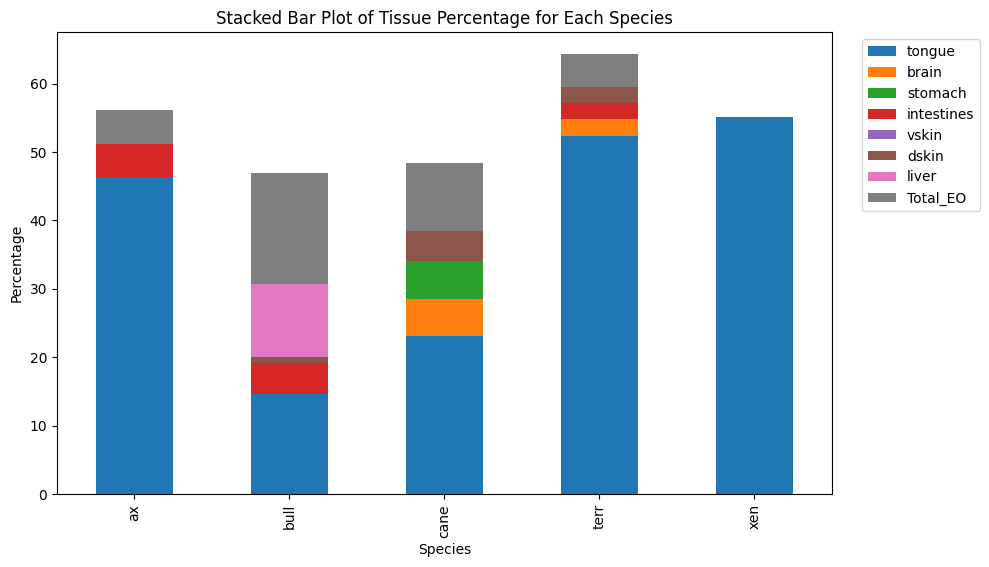

In [91]:
# Plotting
unique_percentage2 = unique_percentage.drop(columns=['Total'])
ax1 = unique_percentage2.plot(kind='bar', stacked=True, figsize=(10, 6))

# Adding labels and title
plt.xlabel('Species')
plt.ylabel('Percentage')
plt.title('Stacked Bar Plot of Tissue Percentage for Each Species')

# Adding legend
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

# Display the plot

plt.savefig('/lab/wengpj01/expression_pipeline/results_20231031/percent_unique_bytissue_stacked.pdf')

/tmp/ipykernel_3600201/2573012725.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['ax', 'bull', 'cane', 'terr', 'xen'], y=fraction_data, palette=custom_palette)


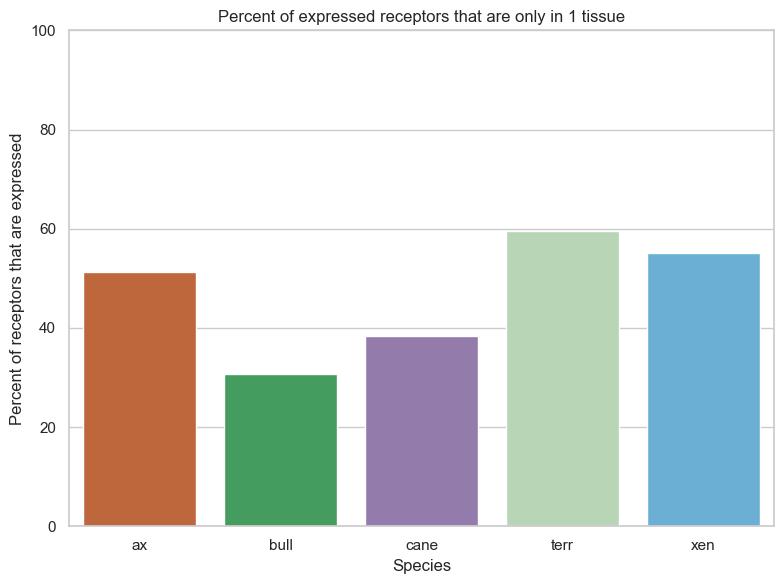

In [92]:
# Generate figure 4E
# Extract the "Fraction" column from results_df
fraction_data = unique_percentage['Total']

# Create a barplot
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")

# Use the custom color palette
custom_palette = ['#D36027', '#35AB58', '#9374B4', '#B4DBAF', '#5AB4E5']
sns.barplot(x=['ax', 'bull', 'cane', 'terr', 'xen'], y=fraction_data, palette=custom_palette)

# Add labels and title
plt.xlabel("Species")
plt.ylabel("Percent of receptors that are expressed")
plt.title("Percent of expressed receptors that are only in 1 tissue")
plt.xticks(range(len(['ax', 'bull', 'cane', 'terr', 'xen'])), ['ax', 'bull', 'cane', 'terr', 'xen'], rotation=0)

plt.ylim(0, 100)

plt.tight_layout()  # Optional: Adjust layout
plt.savefig('/lab/wengpj01/expression_pipeline/results_20231031/percent_unique.pdf')

In [93]:
percentage_table = calculate_percentage(combined_threshold_avg_1, results_df)  #be sure to change calculate_percentage to look at total, not genome
percentage_table

,Tongue,Brain,Stomach,Intestines,VSkin,DSkin,Liver
Species,,,,,,,
ax,43.90,6.51,4.07,6.51,4.88,4.07,22.76
bull,30.00,6.92,3.08,21.28,6.92,7.69,30.77
cane,45.05,28.21,14.65,9.15,13.19,15.02,10.63
terr,67.45,19.05,8.74,9.52,3.98,3.98,1.60
xen,96.59,20.41,23.82,29.94,18.37,8.16,16.33


In [94]:
results_df

,Total,Genome,Fraction
Species,,,
ax,41,70,58.57
bull,130,178,73.03
cane,91,132,68.94
terr,42,63,66.67
xen,49,50,98.00


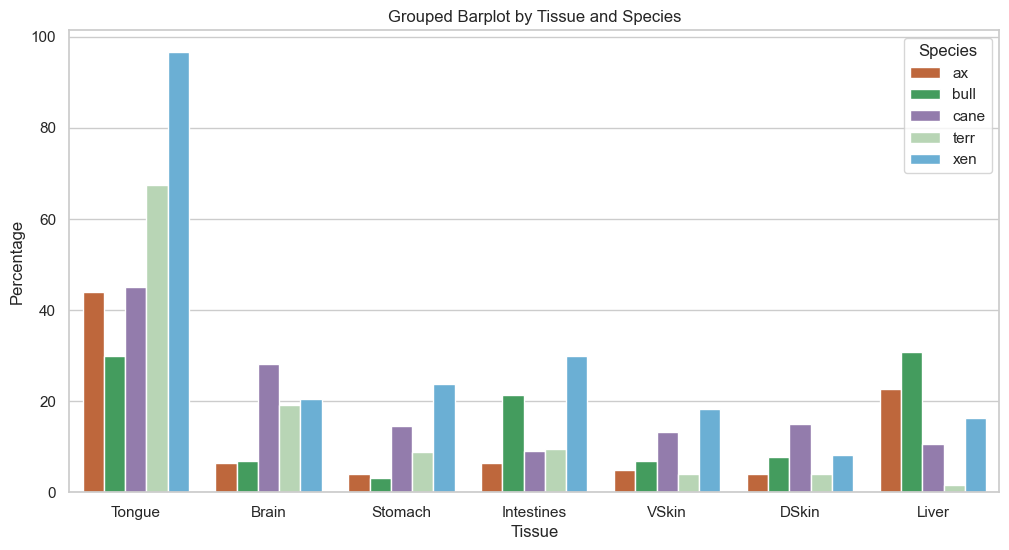

In [95]:
# Generates figure 4D
# Melt the DataFrame to create the grouped barplot
percentage_table_melted = percentage_table.reset_index().melt(id_vars='Species', var_name='Tissue', value_name='Percentage')

plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

# Use 'hue' to color bars based on 'Species' and set custom palette
custom_palette = ['#D36027', '#35AB58', '#9374B4', '#B4DBAF', '#5AB4E5']
sns.barplot(x='Tissue', y='Percentage', hue='Species', data=percentage_table_melted, palette=custom_palette)

# Add labels and title
plt.xlabel('Tissue')
plt.ylabel('Percentage')
plt.title('Grouped Barplot by Tissue and Species')

# Show the legend
plt.legend(title='Species', loc='upper right')
plt.savefig('/lab/wengpj01/expression_pipeline/results_20231031/grouped_by_tissue_01.pdf')

In [96]:
# # Specify the output file path (e.g., "table.tex")
# output_file = '/lab/wengpj01/vertebrate_pipeline/20231006_run/unique_1010.tex'

# # Export the DataFrame as a LaTeX table
# with open(output_file, 'w') as f:
#     f.write(unique_percentage.to_latex(index=True, escape=False))

In [97]:
## Number of receptors that are expressed in at least two replicates
species_data = {
    'ax': ax_min_2,
    'bull': bull_min_2,
    'cane': cane_min_2,
    'terr': terr_min_2,
    'xen': xen_min_2
}

# Calculate the column sums for each DataFrame in species_data
species_column_sums = {species: data.sum() for species, data in species_data.items()}

# Concatenate the DataFrames vertically to create a new DataFrame
combined_min_2 = pd.concat(species_data.values(), keys=species_data.keys(), axis=0)
combined_min_2.reset_index(level=0, inplace=True)
combined_min_2.rename(columns={'level_0': 'Species'}, inplace=True)

# Set the 'Species' column as the row index
combined_min_2.set_index('Species', inplace=True)

# Round the values to two decimal places
combined_min_2 = combined_min_2.round(2)

# Create summary DataFrames for column sums
column_sums_summary = pd.DataFrame(species_column_sums).T
column_sums_summary.index.name = 'Species'

NameError: name 'ax_min_2' is not defined

In [ ]:
column_sums_summary_1 = column_sums_summary
#column_sums_summary_10 = column_sums_summary
column_sums_summary
#column_sums_summary_1

In [ ]:
# merged_df = pd.concat([column_sums_summary_1, results_df], axis=1)
# # Convert 'Total' and 'Genome' columns to integers
# merged_df['Total'] = merged_df['Total'].astype(int)
# merged_df['Genome'] = merged_df['Genome'].astype(int)
# # Reorder the last three columns
# merged_df = merged_df[merged_df.columns[:-3].tolist() + ['Total', 'Genome', 'Fraction']]
# merged_df

# # # Specify the output file path (e.g., "table.tex")
# # output_file = '/lab/wengpj01/vertebrate_pipeline/20231006_run/10count_raw1010.tex'

# # # Export the DataFrame as a LaTeX table
# # with open(output_file, 'w') as f:
# #     f.write(merged_df.to_latex(index=True, escape=False))

In [ ]:
# def normalize_column_sums(column_sums_summary, results_df):
#     # Create an empty DataFrame to store normalized data
#     normalized_data = pd.DataFrame(columns=column_sums_summary.columns)

#     # Iterate through rows in the input DataFrame
#     for index, row in column_sums_summary.iterrows():
#         species = index  # The species name is the row index
#         total = results_df.at[species, 'Total']  # Fetch the corresponding total from results_df
#         # Normalize the row data by dividing by the total
#         normalized_row = (100*row / total).round(2)
#         # Append the normalized row to the result DataFrame
#         normalized_data.loc[index] = normalized_row

#     return normalized_data

In [ ]:
normalized_data = calculate_percentage(column_sums_summary_1, results_df)
normalized_data

In [98]:
# column_sums_summary_100

In [99]:
results_df

,Total,Genome,Fraction
Species,,,
ax,41,70,58.57
bull,130,178,73.03
cane,91,132,68.94
terr,42,63,66.67
xen,49,50,98.00


In [100]:
# def create_colocalization_matrix(species, min_rep, sample_names):
#     # Step 1: Create the species_min_rep DataFrame
#     species_min_rep = create_df_at_least_min(species, min_rep, sample_names)

#     # Step 2: Initialize an empty colocalization matrix with row and column names matching sample_names
#     species_coloc = pd.DataFrame(index=sample_names, columns=sample_names)

#     # Step 3: Fill in the colocalization matrix
#     for row_sample in sample_names:
#         for col_sample in sample_names:
#             if row_sample == col_sample:
#                 # Diagonal elements are set to 1 (same sample)
#                 species_coloc.at[row_sample, col_sample] = 1
#             else:
#                 # Create a temporary matrix with the same number of rows and sample_names as species_min_rep
#                 temp_matrix = pd.DataFrame(index=species_min_rep.index, columns=sample_names)
                
#                 for 

#                 # Check if the value in species_min_rep[row_sample] and species_min_rep[col_sample] is 1 for all rows
#                 temp_matrix = (species_min_rep[row_sample] == 1) & (species_min_rep[col_sample] == 1)

#                 # Calculate the sum of the temporary matrix column and save it in species_coloc[row_sample, col_sample]
#                 species_coloc.at[row_sample, col_sample] = temp_matrix.sum().sum()  # Sum over all rows

#     return species_coloc

# # Example usage:
# # coloc_matrix = create_colocalization_matrix(species, min_rep=2, sample_names=["Tongue", "Brain", "Stomach", "Intestines", "vSkin", "dSkin", "Liver"])
# # This will create the colocalization matrix based on 'species' with the specified criteria and custom sample names.


In [101]:
# create_colocalization_matrix(ax, 2, sample_names)

In [102]:
def calculate_species_colocalization(species_min_rep, sample_names):
    # Create an empty DataFrame 'species_colocalization'
    species_colocalization = pd.DataFrame(index=sample_names, columns=sample_names)

    # Iterate through all combinations of sample_names as both i and j
    for i, j in combinations(sample_names, 2):
        # Create 'temp' DataFrame for i and j
        temp = pd.DataFrame(index=species_min_rep.index, columns=["Result"])
        
        # Iterate across all rows of 'species_min_rep'
        for k, row in species_min_rep.iterrows():
            # Check if species_min_rep[i] == 1 and species_min_rep[j] == 1 in row k
            if row[i] == 1 and row[j] == 1:
                temp.at[k, "Result"] = 1
            else:
                temp.at[k, "Result"] = 0
        
        # Calculate the sum of the "Result" column and store it in 'species_colocalization[i, j]'
        species_colocalization.at[i, j] = temp["Result"].sum()
    
    return species_colocalization

# Example usage:
# species_coloc_matrix = calculate_species_colocalization(species_min_rep, sample_names=["Tongue", "Brain", "Stomach", "Intestines", "vSkin", "dSkin", "Liver"])
# This will create the 'species_colocalization' DataFrame with the calculated colocalization scores.

In [103]:
ax_coloc = calculate_species_colocalization(ax_min_2, sample_names)
bull_coloc = calculate_species_colocalization(bull_min_2, sample_names)
cane_coloc = calculate_species_colocalization(cane_min_2, sample_names)
terr_coloc = calculate_species_colocalization(terr_min_2, sample_names)
xen_coloc = calculate_species_colocalization(xen_min_2, sample_names)

NameError: name 'ax_min_2' is not defined

In [104]:
bull_coloc

NameError: name 'bull_coloc' is not defined

In [105]:
ax_coloc_3 = calculate_species_colocalization(ax_min_3, sample_names)
bull_coloc_3 = calculate_species_colocalization(bull_min_3, sample_names)
cane_coloc_3 = calculate_species_colocalization(cane_min_3, sample_names)
terr_coloc_3 = calculate_species_colocalization(terr_min_3, sample_names)
xen_coloc_3 = calculate_species_colocalization(xen_min_3, sample_names)

NameError: name 'ax_min_3' is not defined

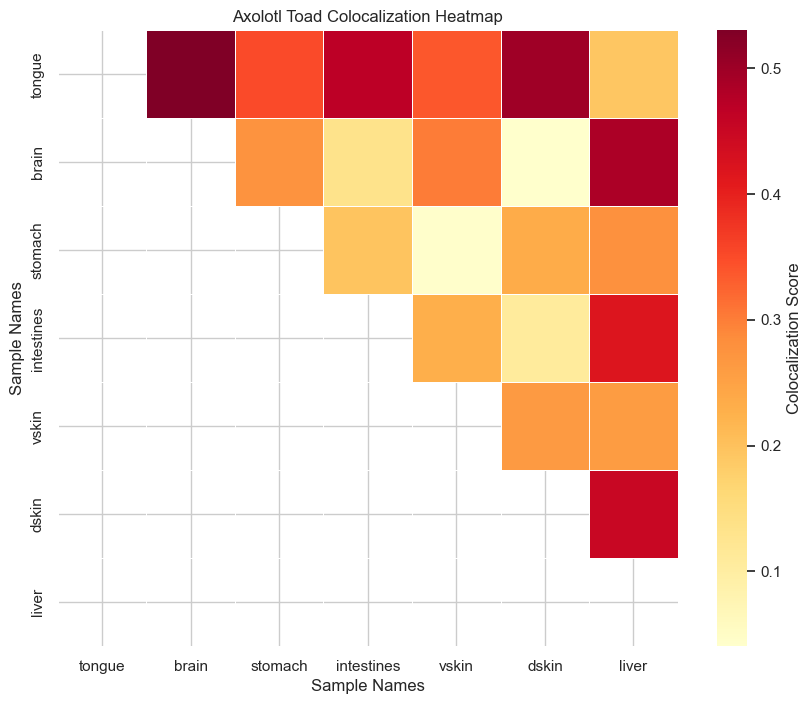

In [106]:
# Create 'cane_coloc_num' with numeric values and empty squares for non-numeric values
ax_coloc_num = ax_euc.applymap(lambda x: x if pd.to_numeric(x, errors='coerce') is not None else '')

# Create a heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed

# Define a color map for the heatmap
# cmap = sns.diverging_palette(220, 20, as_cmap=True, s=85, l=45, sep=20)
cmap = sns.color_palette("YlOrRd", as_cmap=True)

# Create the heatmap with numeric values and empty squares
sns.heatmap(ax_coloc_num, annot=False, fmt='', cmap=cmap, cbar_kws={'label': 'Colocalization Score'}, linewidths=0.5)

# Add labels and title
plt.xlabel("Sample Names")
plt.ylabel("Sample Names")
plt.title("Axolotl Toad Colocalization Heatmap")

plt.savefig("/lab/wengpj01/expression_pipeline/results_20231031/ax_euc.pdf", format="pdf")

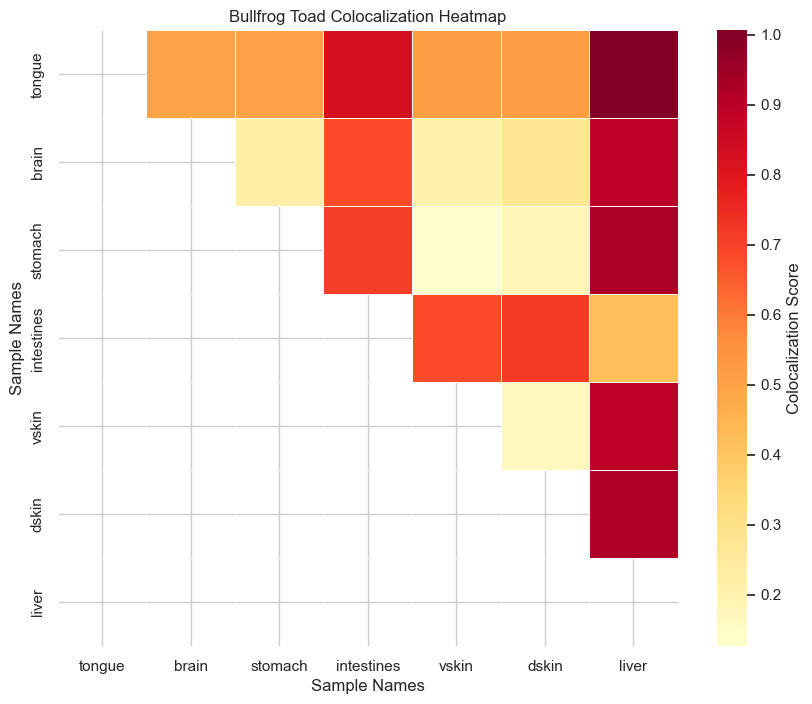

In [107]:
# Create 'cane_coloc_num' with numeric values and empty squares for non-numeric values
bull_coloc_num = bull_euc.applymap(lambda x: x if pd.to_numeric(x, errors='coerce') is not None else '')

# Create a heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed

# Define a color map for the heatmap
# cmap = sns.diverging_palette(220, 20, as_cmap=True, s=85, l=45, sep=20)
cmap = sns.color_palette("YlOrRd", as_cmap=True)

# Create the heatmap with numeric values and empty squares
sns.heatmap(bull_coloc_num, annot=False, fmt='', cmap=cmap, cbar_kws={'label': 'Colocalization Score'}, linewidths=0.5)

# Add labels and title
plt.xlabel("Sample Names")
plt.ylabel("Sample Names")
plt.title("Bullfrog Toad Colocalization Heatmap")

plt.savefig("/lab/wengpj01/expression_pipeline/results_20231031/bull_euc.pdf", format="pdf")

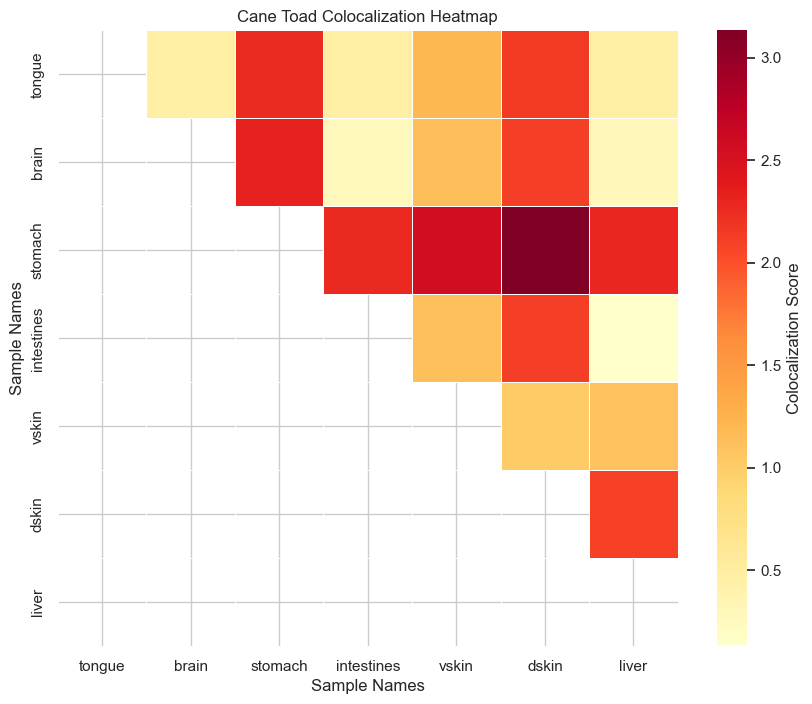

In [108]:
# Create 'cane_coloc_num' with numeric values and empty squares for non-numeric values
cane_coloc_num = cane_euc.applymap(lambda x: x if pd.to_numeric(x, errors='coerce') is not None else '')

# Create a heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed

# Define a color map for the heatmap
# cmap = sns.diverging_palette(220, 20, as_cmap=True, s=85, l=45, sep=20)
cmap = sns.color_palette("YlOrRd", as_cmap=True)

# Create the heatmap with numeric values and empty squares
sns.heatmap(cane_coloc_num, annot=False, fmt='', cmap=cmap, cbar_kws={'label': 'Colocalization Score'}, linewidths=0.5)

# Add labels and title
plt.xlabel("Sample Names")
plt.ylabel("Sample Names")
plt.title("Cane Toad Colocalization Heatmap")

plt.savefig("/lab/wengpj01/expression_pipeline/results_20231031/cane_euc.pdf", format="pdf")

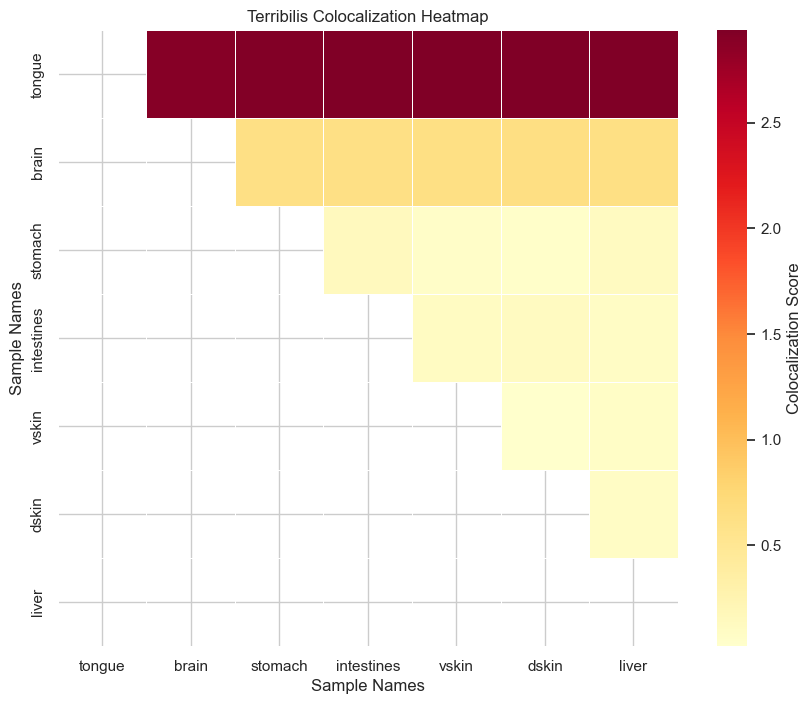

In [109]:
# Create 'cane_coloc_num' with numeric values and empty squares for non-numeric values
terr_coloc_num = terr_euc.applymap(lambda x: x if pd.to_numeric(x, errors='coerce') is not None else '')

# Create a heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed

# Define a color map for the heatmap
# cmap = sns.diverging_palette(220, 20, as_cmap=True, s=85, l=45, sep=20)
cmap = sns.color_palette("YlOrRd", as_cmap=True)

# Create the heatmap with numeric values and empty squares
sns.heatmap(terr_coloc_num, annot=False, fmt='', cmap=cmap, cbar_kws={'label': 'Colocalization Score'}, linewidths=0.5)

# Add labels and title
plt.xlabel("Sample Names")
plt.ylabel("Sample Names")
plt.title("Terribilis Colocalization Heatmap")

plt.savefig("/lab/wengpj01/expression_pipeline/results_20231031/terr_euc.pdf", format="pdf")

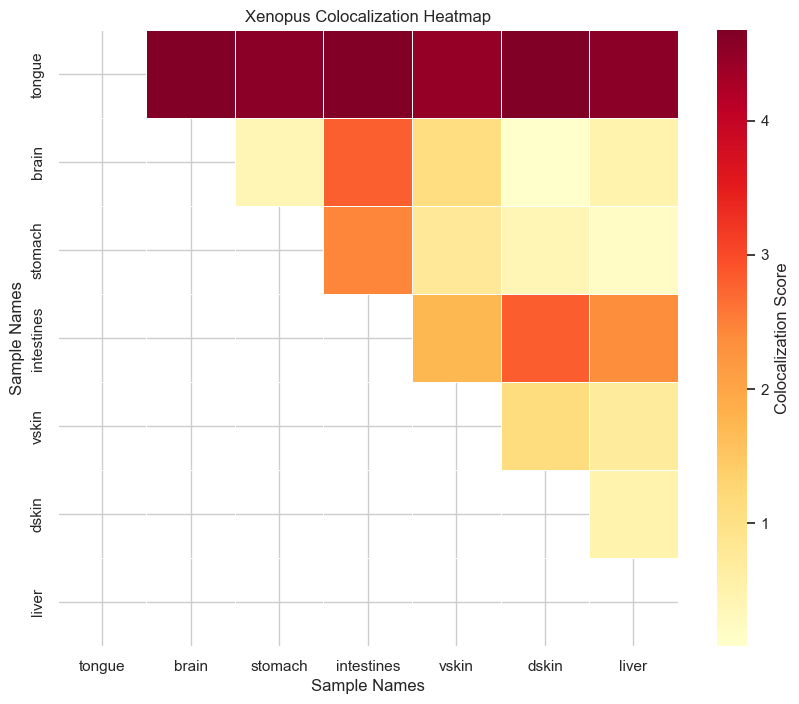

In [110]:
# Create 'cane_coloc_num' with numeric values and empty squares for non-numeric values
xen_coloc_num = xen_euc.applymap(lambda x: x if pd.to_numeric(x, errors='coerce') is not None else '')

# Create a heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed

# # Define a color map for the heatmap
# cmap = sns.diverging_palette(220, 20, as_cmap=True, s=85, l=45, sep=20)
cmap = sns.color_palette("YlOrRd", as_cmap=True)

# Create the heatmap with numeric values and empty squares
sns.heatmap(xen_coloc_num, annot=False, fmt='', cmap=cmap, cbar_kws={'label': 'Colocalization Score'}, linewidths=0.5)

# Add labels and title
plt.xlabel("Sample Names")
plt.ylabel("Sample Names")
plt.title("Xenopus Colocalization Heatmap")

plt.savefig("/lab/wengpj01/expression_pipeline/results_20231031/xen_euc.pdf", format="pdf")

In [111]:
def create_and_save_heatmap(df, sample_name, output_path, global_min, global_max):
    # Create a heatmap
    plt.figure(figsize=(10, 8))  # Adjust the figure size as needed

    # Define a color map for the heatmap
#     cmap = sns.diverging_palette(220, 20, as_cmap=True, s=85, l=45, sep=20)
    cmap = sns.color_palette("YlOrRd", as_cmap=True) #YlOrRd_r

    # Create the heatmap with numeric values and specified vmin and vmax
    sns.heatmap(df, annot=False, fmt='', cmap=cmap, cbar_kws={'label': 'Spearman Coefficient'}, linewidths=0.5,
                vmin=global_min, vmax=global_max)

    # Add labels and title
    plt.xlabel("Sample Names")
    plt.ylabel("Sample Names")
    plt.title(f"{sample_name} Colocalization Heatmap")

    # Save the plot as a PDF file
    plt.savefig(output_path, format="pdf")

In [112]:
# Concatenate the DataFrames vertically (along rows) to create a single DataFrame
all_coloc_num = pd.concat([ax_euc, bull_euc, cane_euc, terr_euc, xen_euc])

# Find the maximum and minimum values across all DataFrames
global_max = all_coloc_num.max().max()
global_min = all_coloc_num.min().min()

# Print or use the global_max and global_min values as needed
print("Global Maximum:", global_max)
print("Global Minimum:", global_min)

Global Maximum: 4.674586505758621
Global Minimum: 0.020916879651826342


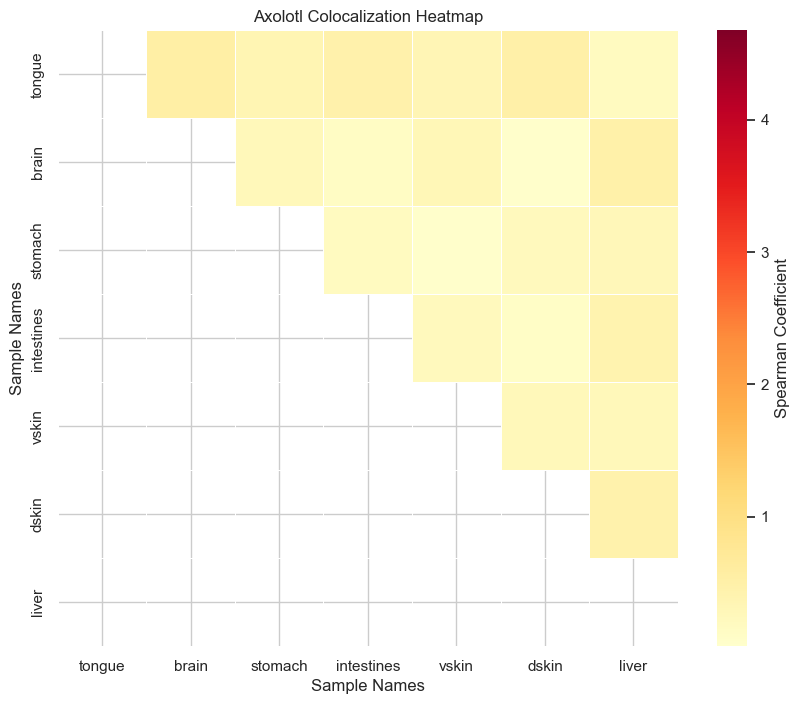

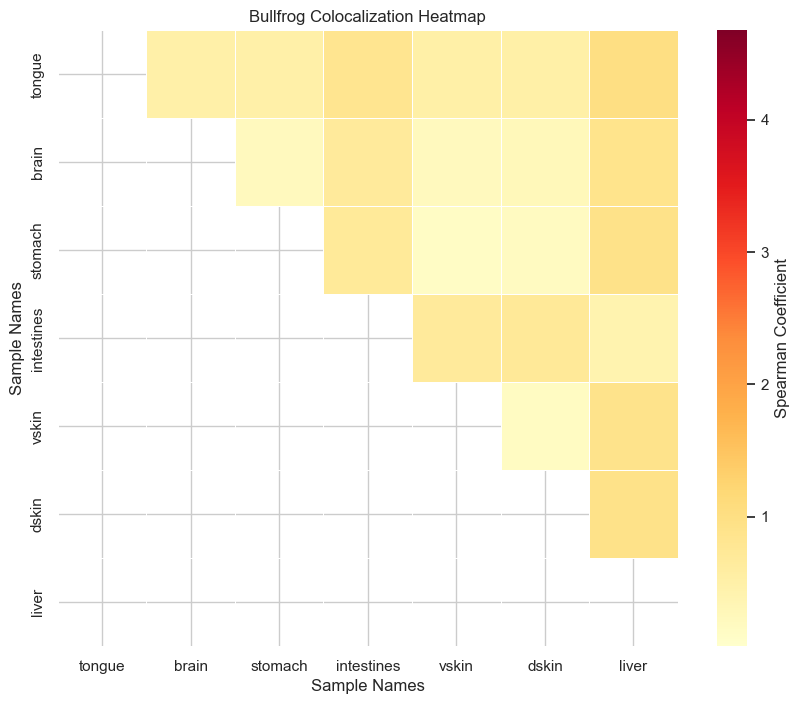

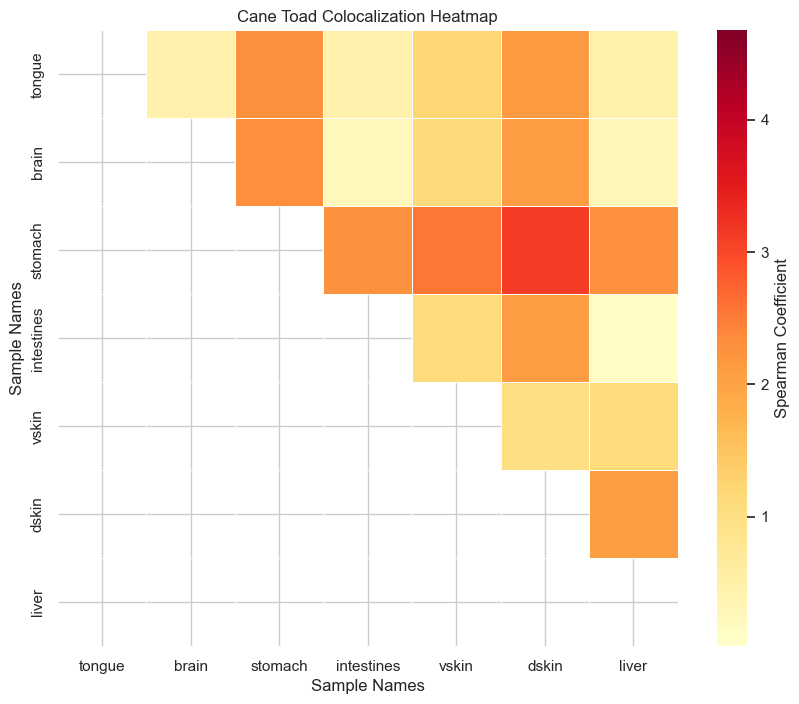

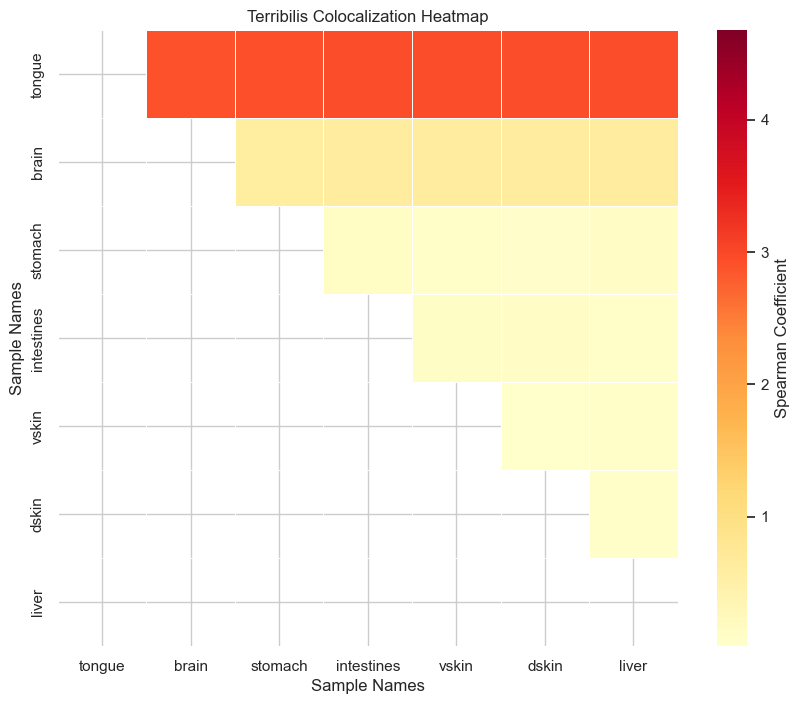

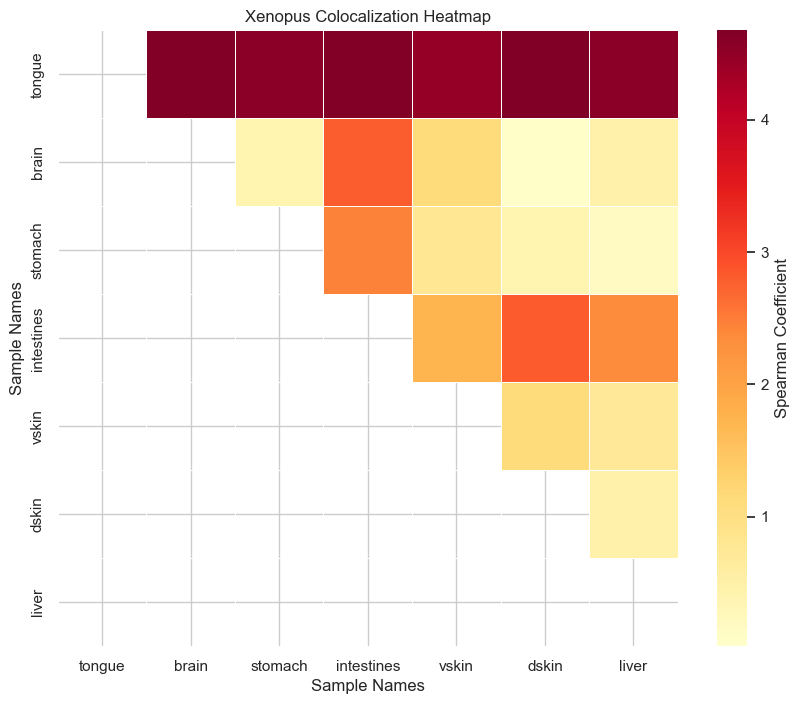

In [113]:
create_and_save_heatmap(ax_euc, "Axolotl", "/lab/wengpj01/expression_pipeline/results_20231031/ax_coloc_euc.pdf", global_min, global_max)
create_and_save_heatmap(bull_euc, "Bullfrog", "/lab/wengpj01/expression_pipeline/results_20231031/bull_coloc_euc.pdf", global_min, global_max)
create_and_save_heatmap(cane_euc, "Cane Toad", "/lab/wengpj01/expression_pipeline/results_20231031/cane_coloc_euc.pdf", global_min, global_max)
create_and_save_heatmap(terr_euc, "Terribilis", "/lab/wengpj01/expression_pipeline/results_20231031/terr_coloc_euc.pdf", global_min, global_max)
create_and_save_heatmap(xen_euc, "Xenopus", "/lab/wengpj01/expression_pipeline/results_20231031/xen_coloc_euc.pdf", global_min, global_max)

In [114]:
(cane_spear > 0.3).sum().sum()

9

In [115]:
xen_spear

,tongue,brain,stomach,intestines,vskin,dskin,liver
tongue,NaN,0.142659,0.213411,0.072617,0.039511,0.079485,0.211119
brain,NaN,NaN,0.464355,0.234456,0.457897,0.241345,0.321477
stomach,NaN,NaN,NaN,0.486595,0.431701,0.415113,0.443591
intestines,NaN,NaN,NaN,NaN,0.543663,0.240804,0.516260
vskin,NaN,NaN,NaN,NaN,NaN,0.196100,0.473624
dskin,NaN,NaN,NaN,NaN,NaN,NaN,0.147285
liver,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Global Maximum: 0.8723376484899487
Global Minimum: -0.2176315857271473


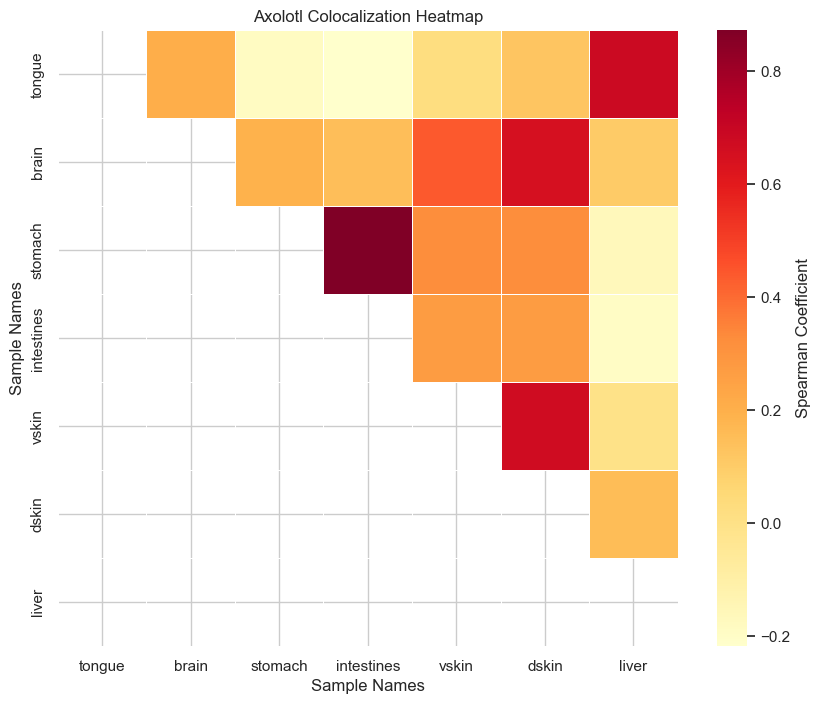

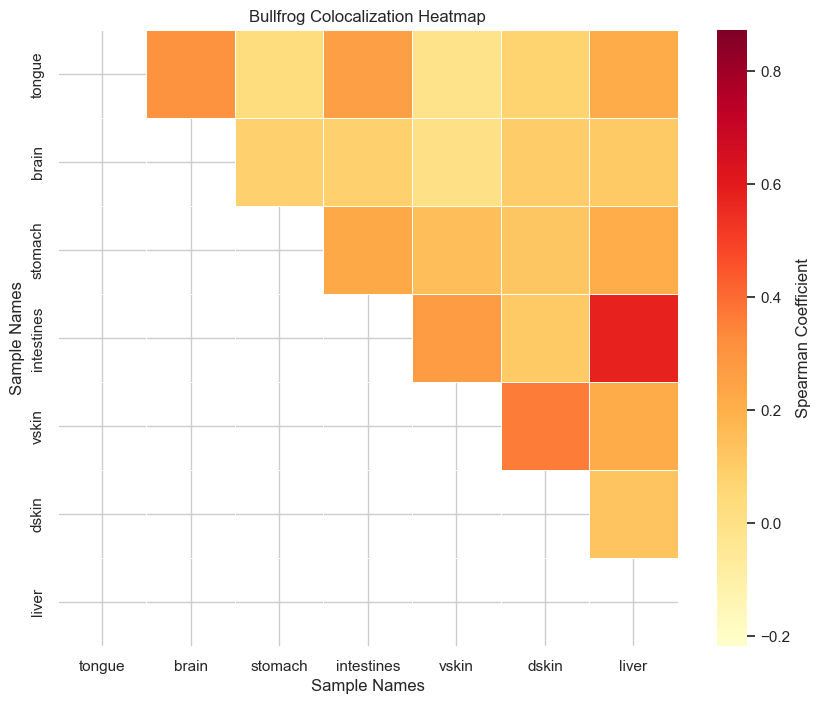

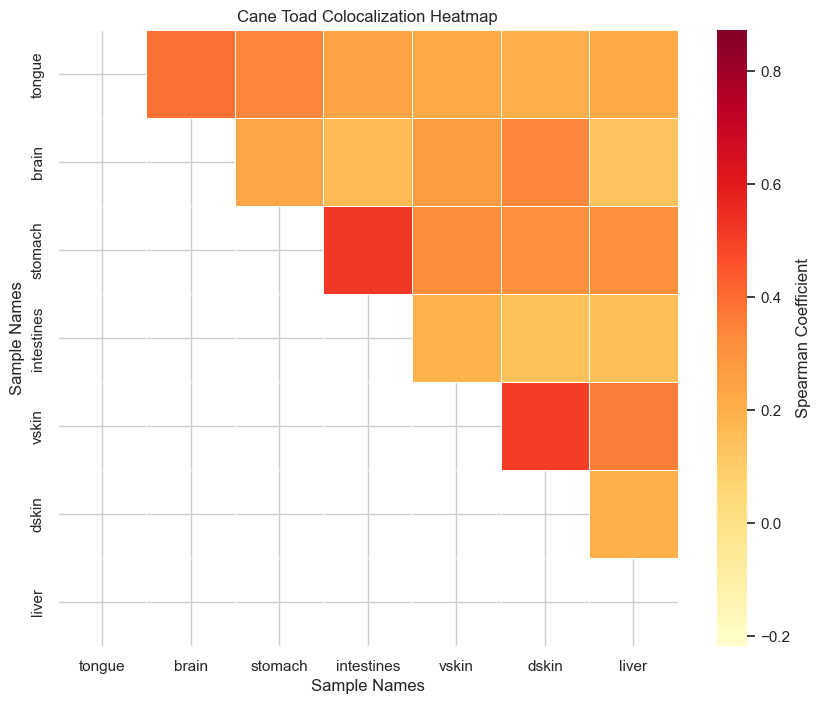

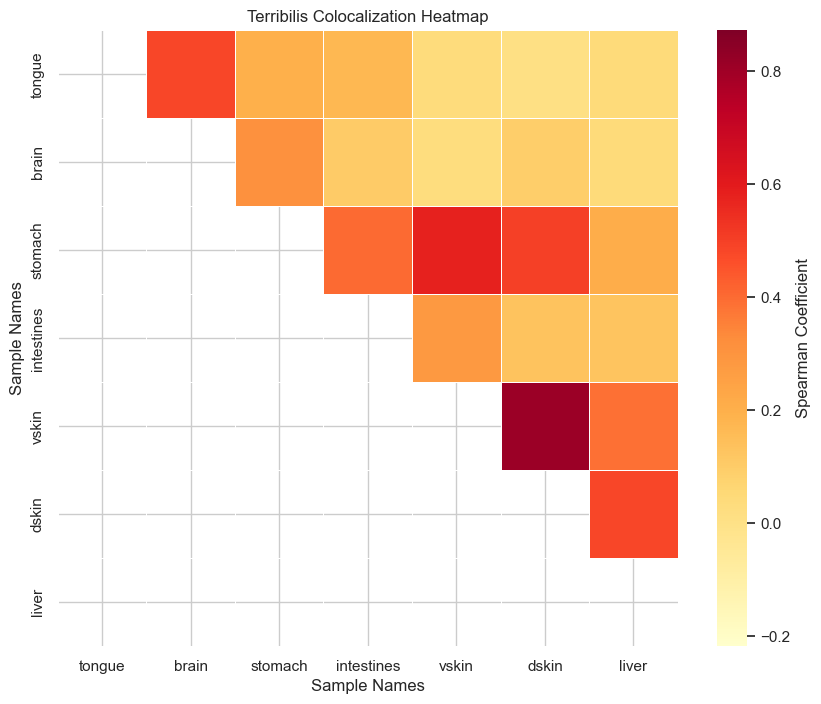

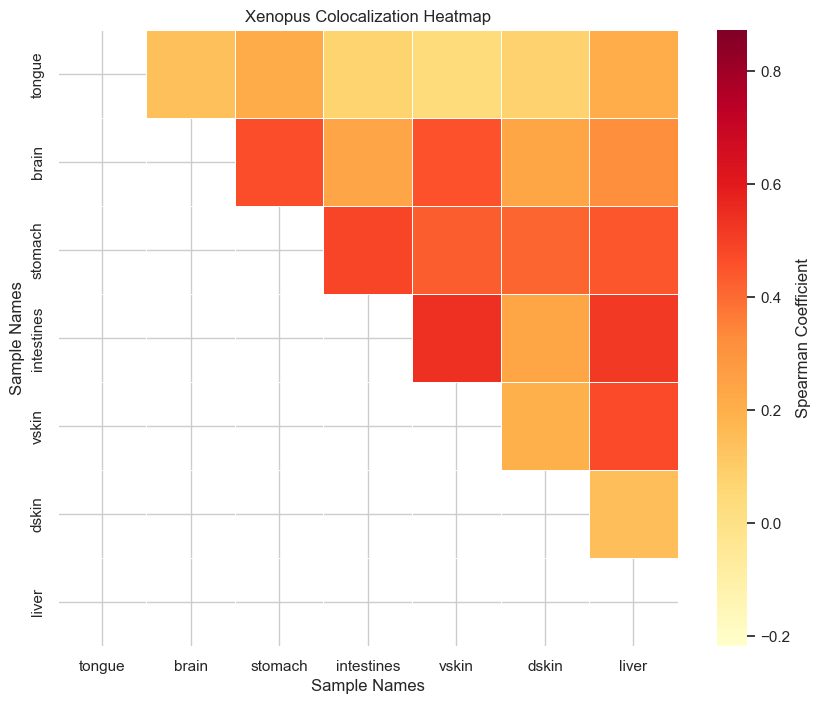

In [116]:
# Generates figure 4G
# Concatenate the DataFrames vertically (along rows) to create a single DataFrame
all_coloc_num = pd.concat([ax_spear, bull_spear, cane_spear, terr_spear, xen_spear])

# Find the maximum and minimum values across all DataFrames
global_max = all_coloc_num.max().max()
global_min = all_coloc_num.min().min()

# Print or use the global_max and global_min values as needed
print("Global Maximum:", global_max)
print("Global Minimum:", global_min)
create_and_save_heatmap(ax_spear, "Axolotl", "/lab/wengpj01/expression_pipeline/results_20231031/ax_spear.pdf", global_min, global_max)
create_and_save_heatmap(bull_spear, "Bullfrog", "/lab/wengpj01/expression_pipeline/results_20231031/bull_spear.pdf", global_min, global_max)
create_and_save_heatmap(cane_spear, "Cane Toad", "/lab/wengpj01/expression_pipeline/results_20231031/cane_spear.pdf", global_min, global_max)
create_and_save_heatmap(terr_spear, "Terribilis", "/lab/wengpj01/expression_pipeline/results_20231031/terr_spear.pdf", global_min, global_max)
create_and_save_heatmap(xen_spear, "Xenopus", "/lab/wengpj01/expression_pipeline/results_20231031/xen_spear.pdf", global_min, global_max)

In [117]:
# Define a function to create and save a log-scaled heatmap
def create_and_save_log_heatmap(df, sample_name, output_path, global_min, global_max):
    # Apply a logarithmic transformation to the data (avoiding zero values)
    df_log = np.log1p(df)

    # Create a heatmap
    plt.figure(figsize=(10, 8))  # Adjust the figure size as needed

    # Define a color map suitable for log-scaled data (e.g., 'YlGnBu')
    cmap = 'YlGnBu'

    # Create the heatmap with log-scaled values and specified vmin and vmax
    sns.heatmap(df_log, annot=True, fmt='.2f', cmap=cmap, cbar_kws={'label': 'Log-Colocalization Score'},
                linewidths=0.5, vmin=np.log1p(global_min), vmax=np.log1p(global_max))

    # Add labels and title
    plt.xlabel("Sample Names")
    plt.ylabel("Sample Names")
    plt.title(f"{sample_name} Log-Colocalization Heatmap")

    # Save the plot as a PDF file
    plt.savefig(output_path, format="pdf")

    # Show the heatmap (optional)
    # plt.show()

In [118]:
# Define a function to format annotations for the heatmap
def annotate_original_value(x, pos):
    return f'{int(x)}'  # Display the original integer value with two decimal places

# Define a function to create and save a log-scaled heatmap with original value annotations
def create_and_save_log_heatmap(df, sample_name, output_path, global_min, global_max):
    # Apply a logarithmic transformation to the data (avoiding zero values)
    df_log = np.log1p(df)

    # Create a heatmap
    plt.figure(figsize=(10, 8))  # Adjust the figure size as needed

    # Define a color map suitable for log-scaled data (e.g., 'YlGnBu')
    cmap = 'YlGnBu'

    # Create the heatmap with log-scaled values and specified vmin and vmax
    sns.heatmap(df_log, annot=True, fmt='', cmap=cmap, cbar_kws={'label': 'Log-Colocalization Score'},
                linewidths=0.5, vmin=np.log1p(global_min), vmax=np.log1p(global_max))

    # Add labels and title
    plt.xlabel("Sample Names")
    plt.ylabel("Sample Names")
    plt.title(f"{sample_name} Log-Colocalization Heatmap")

    # Format the annotations to display the original integer values with two decimal places
    formatter = FuncFormatter(annotate_original_value)
    ax = plt.gca()
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)

    # Save the plot as a PDF file
    plt.savefig(output_path, format="pdf")

    # Show the heatmap (optional)
    # plt.show()


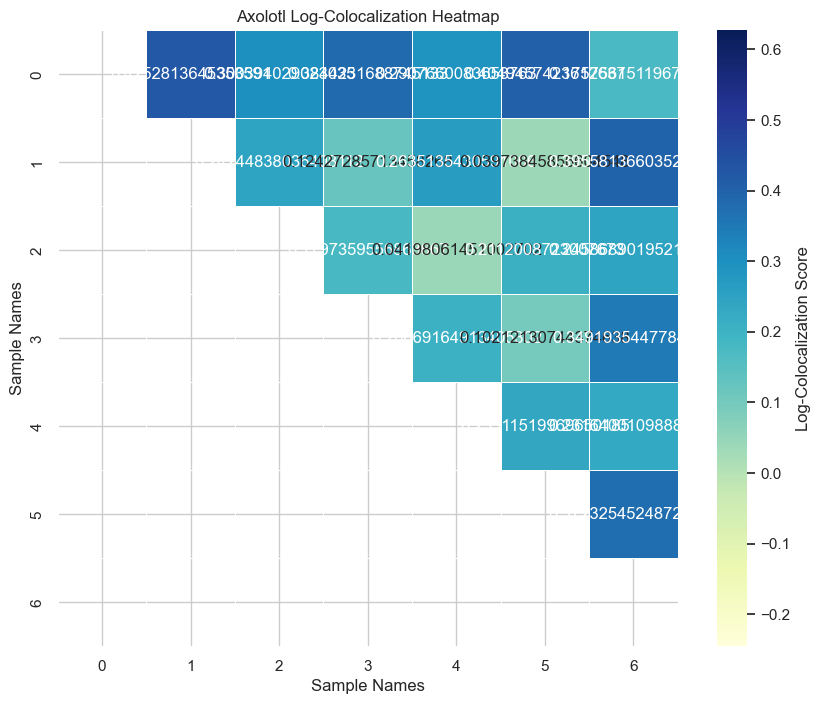

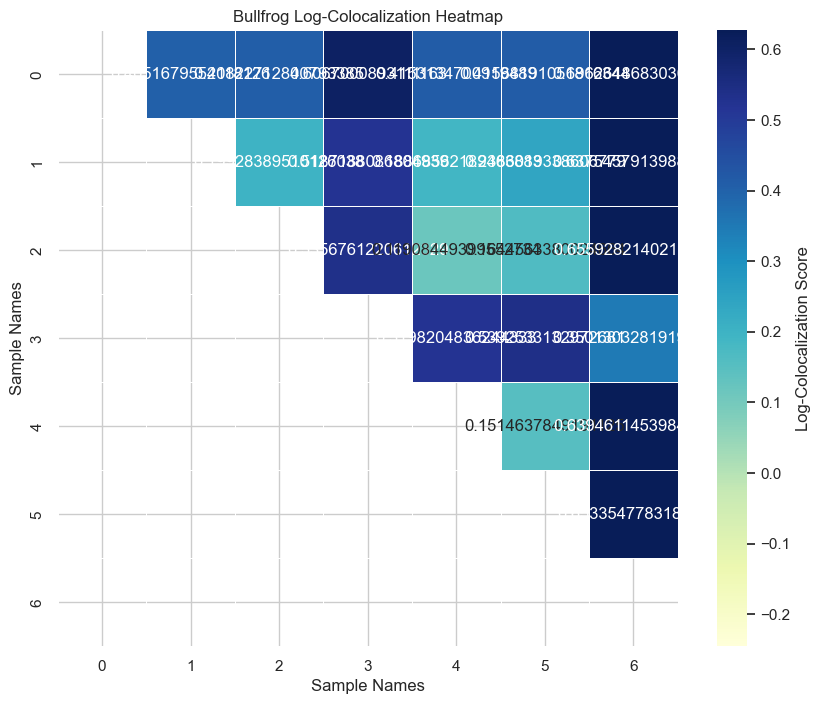

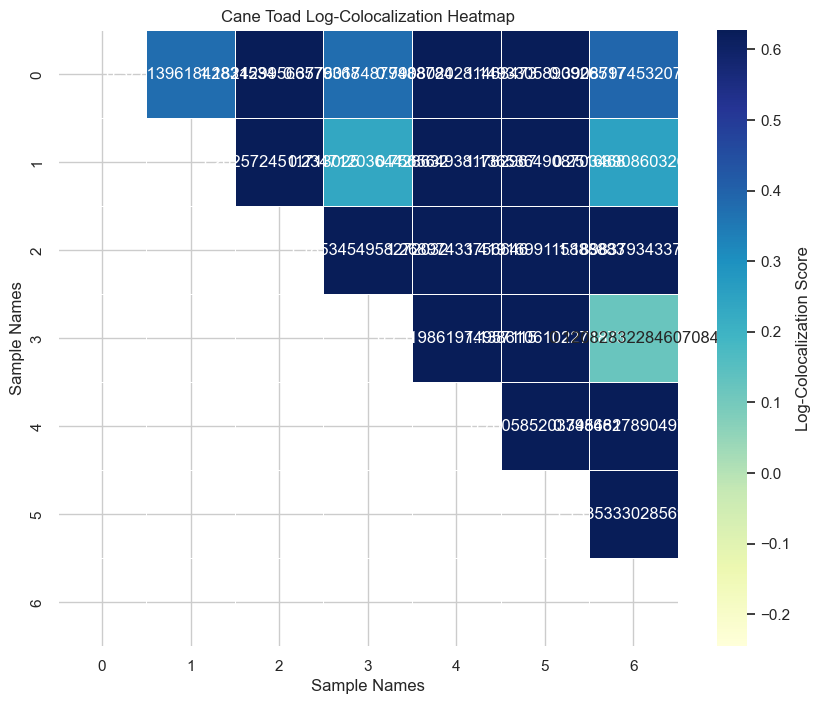

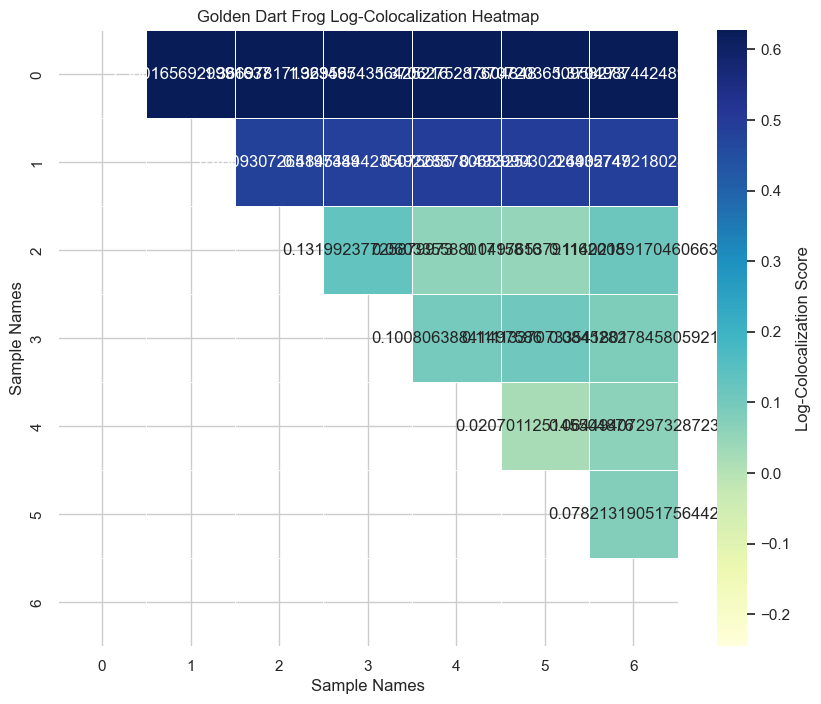

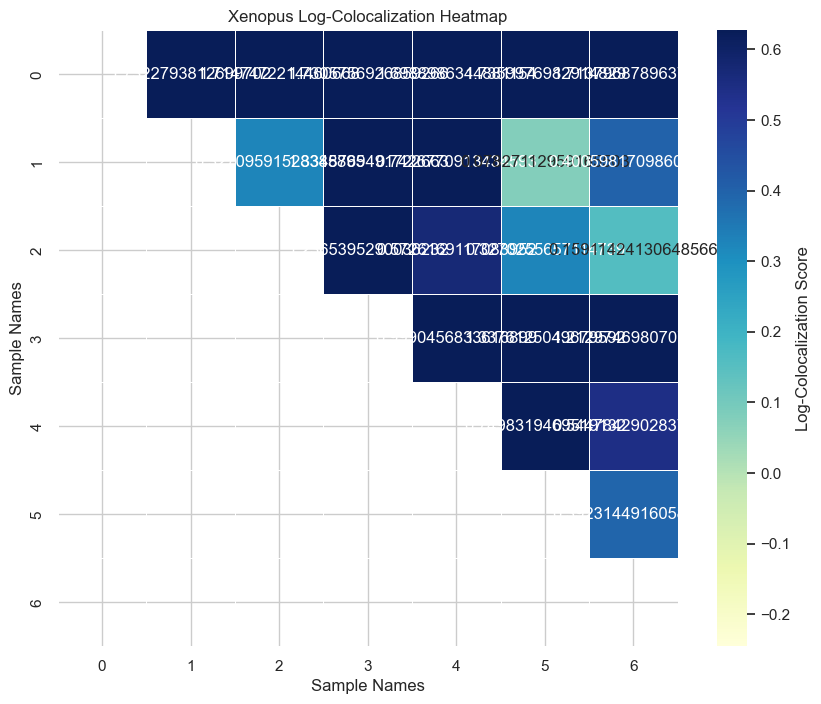

In [119]:
# Call the function for each dataset
create_and_save_log_heatmap(ax_coloc_num, "Axolotl", "/lab/wengpj01/expression_pipeline/results_20231031/ax_coloc_log.pdf", global_min, global_max)
create_and_save_log_heatmap(bull_coloc_num, "Bullfrog", "/lab/wengpj01/expression_pipeline/results_20231031/bull_coloc_log.pdf", global_min, global_max)
create_and_save_log_heatmap(cane_coloc_num, "Cane Toad", "/lab/wengpj01/expression_pipeline/results_20231031/cane_coloc_log.pdf", global_min, global_max)
create_and_save_log_heatmap(terr_coloc_num, "Golden Dart Frog", "/lab/wengpj01/expression_pipeline/results_20231031/terr_coloc_log.pdf", global_min, global_max)
create_and_save_log_heatmap(xen_coloc_num, "Xenopus", "/lab/wengpj01/expression_pipeline/results_20231031/xen_coloc_log.pdf", global_min, global_max)

In [120]:
def create_and_save_heatmap(df, sample_name, species, output_path, global_min, global_max):
    # Normalize the input DataFrame
    # Calculate the normalization factor
    for_norm = results_df.at[species, 'Total']  # Use the species name to fetch the total from results_df

    # Normalize the DataFrame by dividing all values by the normalization factor
    df = 100* df / for_norm

    # Create a heatmap
    plt.figure(figsize=(10, 8))  # Adjust the figure size as needed

    # Define a color map for the heatmap
    cmap = sns.diverging_palette(220, 20, as_cmap=True, s=85, l=45, sep=20)

    # Create the heatmap with numeric values and specified vmin and vmax
    sns.heatmap(df, annot=True, fmt='.2f', cmap=cmap, cbar_kws={'label': 'Colocalization Score'}, linewidths=0.5,
                vmin=global_min, vmax=global_max)

    # Add labels and title
    plt.xlabel("Sample Names")
    plt.ylabel("Sample Names")
    plt.title(f"{sample_name} Colocalization Heatmap")

    # Save the plot as a PDF file
    plt.savefig(output_path, format="pdf")

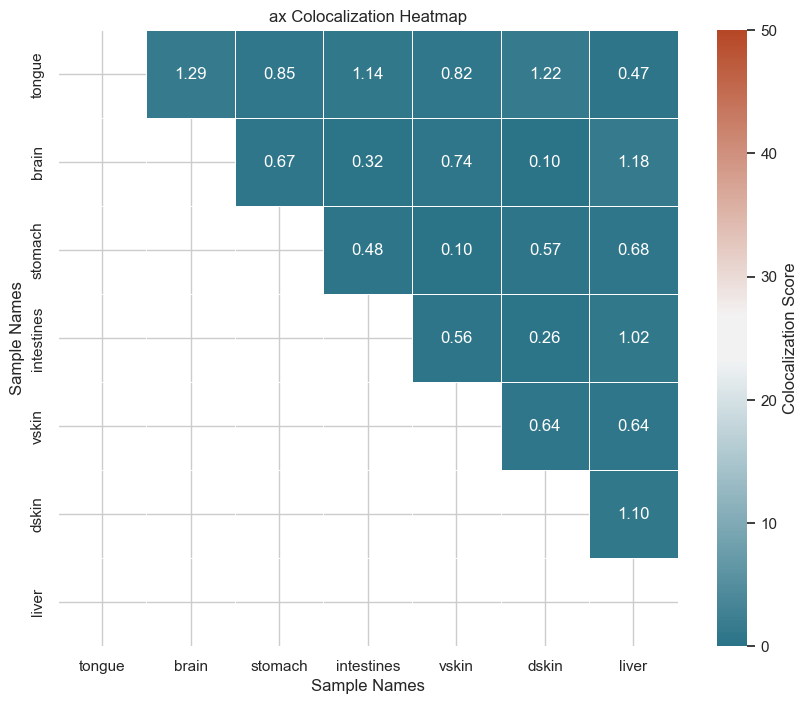

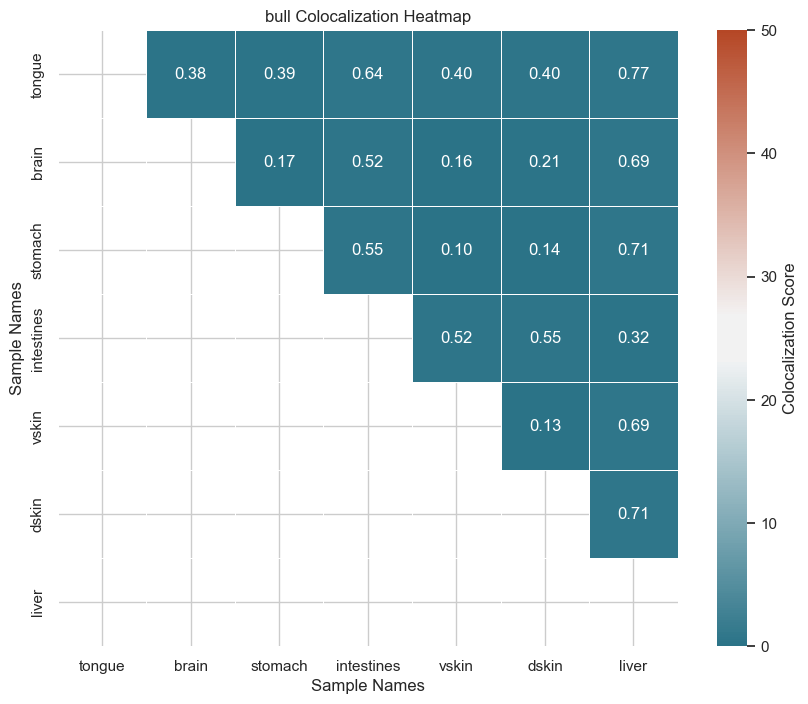

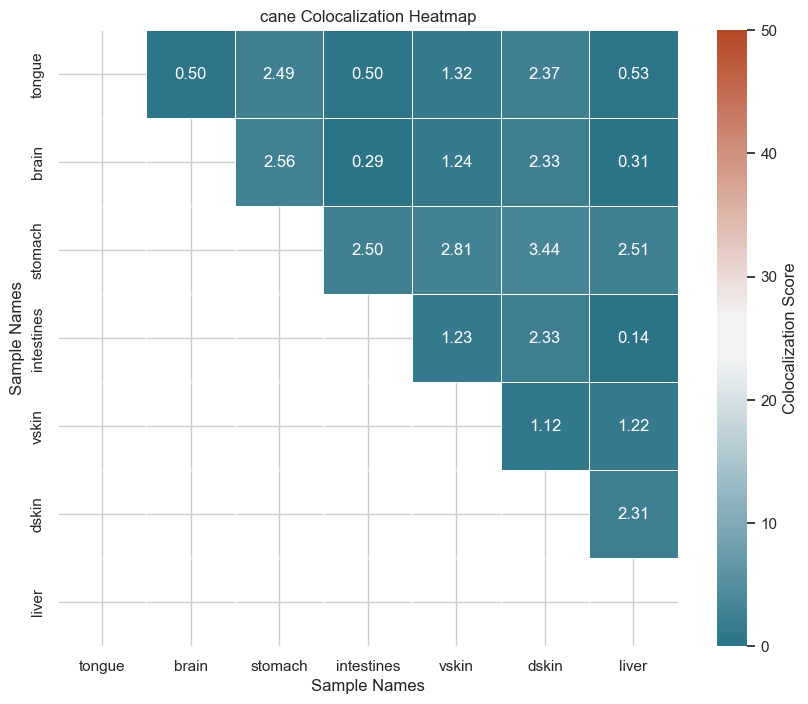

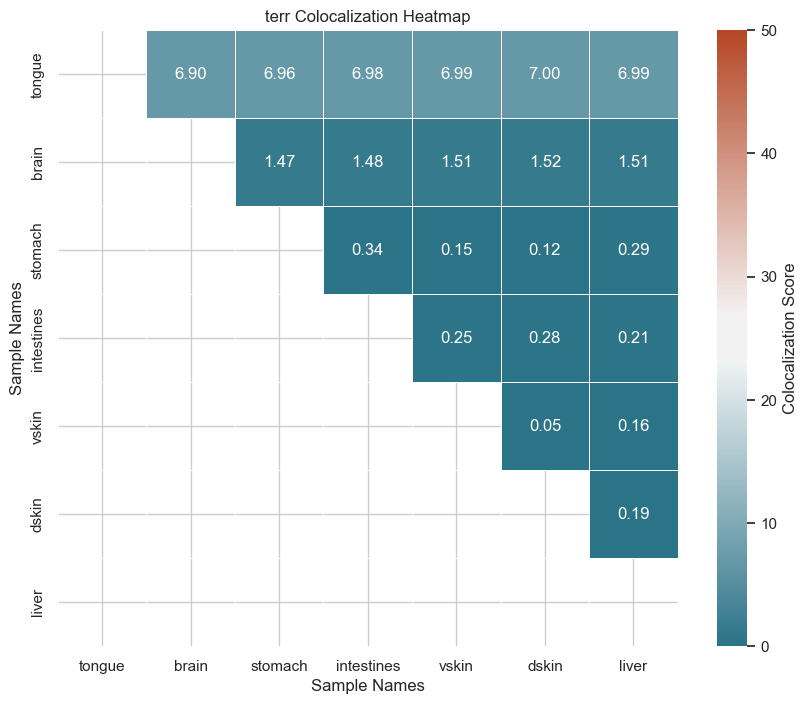

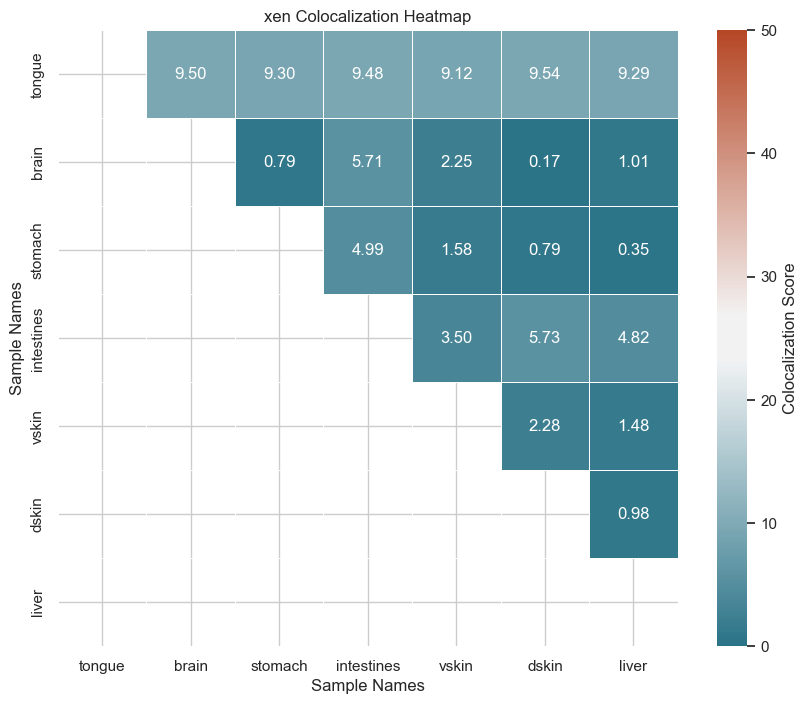

In [121]:
# create_and_save_heatmap(ax_coloc_num, "Axolotl", "/lab/wengpj01/expression_pipeline/results_20231031/ax_coloc_norm.pdf", 0, 1)
create_and_save_heatmap(ax_coloc_num, "ax", "ax", "/lab/wengpj01/expression_pipeline/results_20231031/ax_coloc_norm.pdf", 0, 50)
create_and_save_heatmap(bull_coloc_num, "bull", "bull", "/lab/wengpj01/expression_pipeline/results_20231031/bull_coloc_norm.pdf", 0, 50)
create_and_save_heatmap(cane_coloc_num, "cane", "cane", "/lab/wengpj01/expression_pipeline/results_20231031/cane_coloc_norm.pdf", 0, 50)
create_and_save_heatmap(terr_coloc_num, "terr", "terr", "/lab/wengpj01/expression_pipeline/results_20231031/terr_coloc_norm.pdf", 0, 50)
create_and_save_heatmap(xen_coloc_num, "xen", "xen", "/lab/wengpj01/expression_pipeline/results_20231031/xen_coloc_norm.pdf", 0, 50)

In [122]:
def create_and_save_heatmap(df, sample_name, species, output_path):
    # Normalize the input DataFrame
    # Calculate the normalization factor
    for_norm = results_df.at[species, 'Total']  # Use the species name to fetch the total from results_df

    # Normalize the DataFrame by dividing all values by the normalization factor
    df = df / for_norm

    # Determine the minimum and maximum values from the DataFrame
    vmin = df.values.min()
    vmax = df.values.max()

    # Create a heatmap
    plt.figure(figsize=(10, 8))  # Adjust the figure size as needed

    # Define a color map for the heatmap
    cmap = sns.diverging_palette(220, 20, as_cmap=True, s=85, l=45, sep=20)

    # Create the heatmap with numeric values and automatically determined vmin and vmax
    sns.heatmap(df, annot=True, fmt='.2f', cmap=cmap, cbar_kws={'label': 'Colocalization Score'}, linewidths=0.5,
                vmin=vmin, vmax=vmax)

    # Add labels and title
    plt.xlabel("Sample Names")
    plt.ylabel("Sample Names")
    plt.title(f"{sample_name} Colocalization Heatmap")

    # Save the plot as a PDF file
    plt.savefig(output_path, format="pdf")

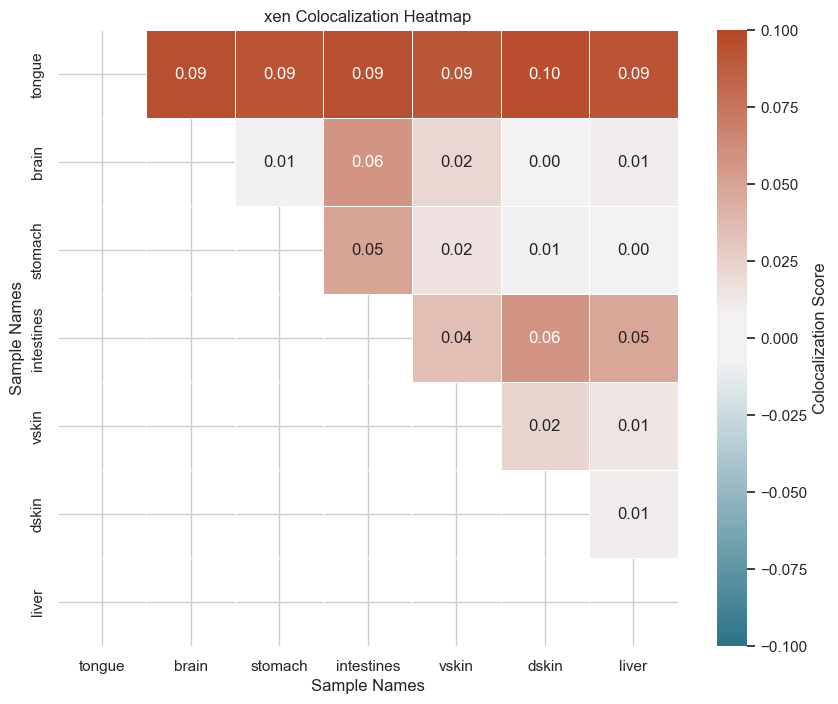

In [123]:
create_and_save_heatmap(xen_coloc_num, "xen", "xen", "/lab/wengpj01/expression_pipeline/results_20231031/xen_coloc_norm.pdf")